In [270]:
import pandas as pd
import keras 
import numpy as np
from ggplot import * 
import matplotlib.pyplot as plt
from datetime import datetime
import random
from scipy import sparse
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
%matplotlib inline

In [271]:
time_payment = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ID_Payment.txt')
time_payment.columns = ['UID', 'TransTime', 'DepositAmount']
time_payment['TransDate'] = time_payment.TransTime.apply(
                                    lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
time_payment['TransTime'] = time_payment.TransTime.apply(
                                    lambda x: datetime.strptime(x[:19], "%Y-%m-%d %H:%M:%S"))
time_payment['Weekday'] = time_payment.TransTime.apply(lambda x: x.weekday())

print(time_payment.shape)
time_payment.head(10)


(137460, 5)


,UID,TransTime,DepositAmount,TransDate,Weekday
0,3352496,2017-01-31 00:42:35,500,2017-01-31,1
1,3352496,2018-02-19 10:53:55,500,2018-02-19,0
2,3458960,2017-07-20 17:57:17,500,2017-07-20,3
3,3458960,2017-08-03 19:05:40,1000,2017-08-03,3
4,3458960,2017-08-25 19:01:55,150,2017-08-25,4
5,3458960,2017-08-26 21:00:24,1000,2017-08-26,5
6,3458960,2017-09-19 15:21:14,500,2017-09-19,1
7,3458960,2017-01-16 16:26:41,1150,2017-01-16,0
8,3458960,2018-02-02 11:55:45,300,2018-02-02,4
9,3458960,2018-02-08 17:45:14,1000,2018-02-08,3


In [272]:
# character data -> use from the 23th entry(?)
character = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/Character.txt')
character.columns = ['SN', 'ServerNo', 'CharaID', 'UID', 'Career','P1', 'P2', 'CashAmount',
                    'Popularity', 'Gender', 'SpouseID', 'ReinTimes', 'ReinLevel', '1stRein','2ndRein','P3',
                    'P4','P5','P6','P7','P8']

character.iloc[19:22,:]
character_normal = character.iloc[21:, :]
character_abnormal = character.iloc[:21,:]

character = character_normal

character.head()

,SN,ServerNo,CharaID,UID,Career,P1,P2,CashAmount,Popularity,Gender,...,ReinTimes,ReinLevel,1stRein,2ndRein,P3,P4,P5,P6,P7,P8
21,"43,45",1,1218,45203061,0,100,6,0,1741,0,...,0,0,0,0,0,0,0,0,0,0
22,"44,46",1,1220,45203061,11,41,4,5023405,857,0,...,0,0,0,0,0,0,0,0,0,0
23,"45,47",1,1234,11374352,7,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24,"46,48",1,1248,29471424,3,4,0,1618,7,1,...,0,0,0,0,0,0,0,0,0,0
25,"47,49",1,1264,31094496,0,9,0,7093,17,0,...,0,0,0,0,0,0,0,0,0,0


In [273]:
''' From 2017/6/23 ~ 2018/10/9
'''

login = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ID_Login.txt')
login.columns = ['UID', 'LoginDate']
login['LoginDate'] =login.LoginDate.apply(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'))

# add weekday into column
from datetime import datetime
login['Weekday'] = login.LoginDate.apply(lambda x: x.weekday())

print(login.shape)
login.head()

(8875989, 3)


,UID,LoginDate,Weekday
0,42954752,2018-04-16,0
1,45436584,2018-04-16,0
2,5041824,2018-04-16,0
3,45436382,2018-04-16,0
4,13871120,2018-04-16,0


In [75]:
''' Proportion of gender
'''
# gender_prop_serie = character.groupby('UID').agg('sum').Gender.value_counts()
female_pop = gender_prop_serie[0]
male_pop = sum(gender_prop_serie[1:])
# total_pop = female_pop+male_pop
print('There is {} female and {} male characters'.format(female_pop, male_pop))
# print(female_pop)
# print(male_pop)

There is 819375 female and 1135955 male characters


In [274]:
item_server = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ID_ItemID_Num_Server.txt')
item_server.columns = ['UID', 'RecordTime', 'ItemID', 'ItemNum', 'ServerNo']
print(item_server.shape) # only 9/3, 8/27, 9/17

item_type = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemID_ItemType.txt')
item_set = pd.read_table('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemID_SetType.txt')

item_type = item_type.set_index('ItemID').to_dict()['ItemType']
item_set = item_set.set_index('ItemID').to_dict()['SetType']

item_server['ItemType'] = item_server.iloc[:, 2].apply(lambda x: item_type.get(x))
item_server['SetType'] = item_server.iloc[:, 2].apply(lambda x: item_set.get(x))
# # item_server.iloc[:5, 2].apply(lambda x: item_type[str(x)])
item_server.head()

(713582, 5)


,UID,RecordTime,ItemID,ItemNum,ServerNo,ItemType,SetType
0,45499277,2018-09-03 06:30:00.000,52216,1,4,TypeA,None
1,45499285,2018-09-03 06:30:00.000,41815,1,4,TypeB,None
2,45499287,2018-09-03 06:30:00.000,39872,1,4,TypeE,None
3,45499287,2018-09-03 06:30:00.000,41802,1,4,TypeB,SetC
4,45499287,2018-09-03 06:30:00.000,41819,1,4,TypeB,None


In [112]:
set(item_server.RecordTime)

{'2018-08-27 06:30:00.000',
 '2018-09-03 06:30:00.000',
 '2018-09-17 06:30:00.000'}

In [110]:
purchase_set = set(item_server.UID)
chara_set = set(character.UID)
print(len(purchase_set)) # 51175
print(len(chara_set)) # 1955330

print(len(purchase_set & chara_set))

51175
1955330
51175


In [4]:
type(item_server.ItemID.iloc[0])

numpy.int64

In [7]:
# item_server.to_csv('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/item_english_title.csv',
#                   sep=',')

In [8]:
# item_server.groupby(['ItemID', 'ItemType']).count()
item_stat = item_server.groupby(['ItemID'])['ItemNum'].agg(['count', 'sum', 'std']) #count for each itemID & average Num & sdNum
item_stat.head()

,count,sum,std
ItemID,,,
12980,33408,2499176,399.814014
15038,53773,1203404,113.593159
15039,25927,135227,16.356787
15040,18551,46901,6.667954
15041,7856,12331,2.976759


In [ ]:
# plot1 - x:count, y: times


In [ ]:
# plot2 - x: sum, y:times


# Recommendation System

### 是否標準化？ 不影響相關係數結果
### 是否填NA？ NA: 消費者不知道這間產品 ０: 消費者對這產品沒興趣

In [6]:
# item_pivot = item_server.pivot_table(index='UID', columns='ItemID', values='ItemNum') 
import pandas as pd
item_pivot = pd.read_csv('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemUserPivotDF.csv',index_col = 0)
item_pivot.head(3)


,12980,15038,15039,15040,15041,15042,15043,15044,15045,15046,...,52213,52214,52215,52216,52217,52218,52219,52220,52221,52222
UID,,,,,,,,,,,,,,,,,,,,,
32,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,41.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# standardized the original data(above)
# 不填NA 
# ref: https://datascience.stackexchange.com/questions/9454/how-to-deal-with-a-sparse-matrix-when-using-a-perceptron-based-recommender-syste
from sklearn import preprocessing

# standardize the data attributes
item_pivot_std = preprocessing.scale(item_pivot)
item_pivot_std_df = pd.DataFrame(item_pivot_std, columns=item_pivot.columns, index=item_pivot.index)
item_pivot_std_df.head(3)

,12980,15038,15039,15040,15041,15042,15043,15044,15045,15046,...,52213,52214,52215,52216,52217,52218,52219,52220,52221,52222
UID,,,,,,,,,,,,,,,,,,,,,
32,NaN,NaN,-0.201103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,0.023268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,-0.104424,NaN,-0.263746,-0.249884,-0.20376,NaN,-0.086364,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def find_corr(column, pivot_matrix, threshold=None):
    
    itemNum = column.sort_values(ascending=False)
    corr = pivot_matrix.corrwith(itemNum).sort_values(ascending=False)
    
    if threshold:
        corr = corr[corr >= threshold]
    
    return corr

# volume from each user about a certain product

# correlation matrix between each product ( based on Item dataset )

In [7]:
# item_corr_df = item_pivot_original_std_df.apply(lambda x: find_corr(x, item_pivot_original)) # with NaN
# item_corr_df.head() # has been saved to csv in '/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemCorrelationDF.csv'

item_corr_df = pd.read_csv('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemCorrelationDF.csv', 
                          index_col=0)
item_corr_df.head()

,12980,15038,15039,15040,15041,15042,15043,15044,15045,15046,...,52213,52214,52215,52216,52217,52218,52219,52220,52221,52222
ItemID,,,,,,,,,,,,,,,,,,,,,
12980,1.000000,0.230074,0.286195,0.385480,0.159421,0.107033,0.273193,0.136094,0.431571,0.116208,...,NaN,NaN,0.083343,0.072224,-0.027477,0.031165,-0.042626,-0.019983,0.780009,0.868659
15038,0.230074,1.000000,0.675909,0.715137,0.347262,0.183958,0.392077,0.048990,0.202089,-0.017643,...,NaN,NaN,0.040713,0.050936,-0.022774,0.238451,0.015488,-0.098275,0.035067,0.958421
15039,0.286195,0.675909,1.000000,0.766924,0.531192,0.206984,0.584298,0.009790,0.295342,-0.067768,...,NaN,NaN,0.056840,0.004560,0.012353,0.159934,0.015931,-0.161376,0.164739,0.105550
15040,0.385480,0.715137,0.766924,1.000000,0.593037,0.162717,0.513292,-0.003390,0.640960,-0.044817,...,NaN,NaN,0.084536,0.031408,-0.047473,0.197476,-0.042988,-0.207781,-0.104883,NaN
15041,0.159421,0.347262,0.531192,0.593037,1.000000,0.562955,0.330749,-0.007984,0.295224,-0.059498,...,NaN,NaN,0.034008,-0.003997,0.054216,0.029167,0.153480,-0.090469,-0.353553,NaN


# correlation matrix between each user ( based on Item dataset)

In [17]:
# transpose the matrix and standardize
uid_pivot_original = item_pivot_original.transpose()

uid_pivot_original_std = preprocessing.scale(uid_pivot_original)
uid_pivot_original_std_df = pd.DataFrame(uid_pivot_original_std, columns=item_pivot.index, index=item_pivot.columns)
uid_pivot_original_std_df.head(3)

NameError: name 'item_pivot_original' is not defined

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances 

user_similarity = pairwise_distances(item_pivot_std_df.fillna(0).values , metric='cosine') # cannot have NaN
# pairwise_distances(item_pivot_original_std.values , metric='cosine')

# item_pivot_std_df.fillna(0) # 做不出來會噴射(??????)


# Building a simple popularity and collaborative filtering model using Turicreate

In [9]:
import turicreate as tc
test_item_server = tc.SFrame(item_server)
training, validation = tc.recommender.util.random_split_by_user(
    test_item_server, 'UID','ItemID') # 710556 vs 3026

In [22]:
''' train model and make recommendation for user of only new item
'''

%time model = tc.recommender.create(training, 'UID', 'ItemID')

recom = model.recommend(k=6) # SFrame
recom.print_rows(100) # score vary a lot

Recsys training: model = item_similarity

Warning: Ignoring columns RecordTime, ItemNum, ServerNo, ItemType, SetType;

To use one of these as a target column, set target = <column_name>

and use a method that allows the use of a target.

Preparing data set.

Data has 710556 observations with 51170 users and 133 items.

Data prepared in: 0.563495s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.054ms                        | 1.75       |

| 34.028ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 54.997ms                            | 0                | 0               |

| 93.427ms                            | 100              | 133             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.156139s

CPU times: user 1.26 s, sys: 224 ms, total: 1.49 s
Wall time: 729 ms


recommendations finished on 1000/51170 queries. users per second: 57139.6

recommendations finished on 2000/51170 queries. users per second: 68455.6

recommendations finished on 3000/51170 queries. users per second: 83033.5

recommendations finished on 4000/51170 queries. users per second: 81398.4

recommendations finished on 5000/51170 queries. users per second: 83511.5

recommendations finished on 6000/51170 queries. users per second: 87061.2

recommendations finished on 7000/51170 queries. users per second: 91006

recommendations finished on 8000/51170 queries. users per second: 89852.3

recommendations finished on 9000/51170 queries. users per second: 93661.2

recommendations finished on 10000/51170 queries. users per second: 99570.8

recommendations finished on 11000/51170 queries. users per second: 101646

recommendations finished on 12000/51170 queries. users per second: 103725

recommendations finished on 13000/51170 queries. users per second: 107150

recommendations finished on 14000/51170 queries. users per second: 109986

recommendations finished on 15000/51170 queries. users per second: 114002

recommendations finished on 16000/51170 queries. users per second: 114516

recommendations finished on 17000/51170 queries. users per second: 115770

recommendations finished on 18000/51170 queries. users per second: 117642

recommendations finished on 19000/51170 queries. users per second: 120857

recommendations finished on 20000/51170 queries. users per second: 123249

recommendations finished on 21000/51170 queries. users per second: 123350

recommendations finished on 22000/51170 queries. users per second: 126127

recommendations finished on 23000/51170 queries. users per second: 128216

recommendations finished on 24000/51170 queries. users per second: 129945

recommendations finished on 25000/51170 queries. users per second: 131118

recommendations finished on 26000/51170 queries. users per second: 131722

recommendations finished on 27000/51170 queries. users per second: 131918

recommendations finished on 28000/51170 queries. users per second: 133358

recommendations finished on 29000/51170 queries. users per second: 134935

recommendations finished on 30000/51170 queries. users per second: 133276

recommendations finished on 31000/51170 queries. users per second: 135615

recommendations finished on 32000/51170 queries. users per second: 135975

recommendations finished on 33000/51170 queries. users per second: 135956

recommendations finished on 34000/51170 queries. users per second: 136645

recommendations finished on 35000/51170 queries. users per second: 137884

recommendations finished on 36000/51170 queries. users per second: 138840

recommendations finished on 37000/51170 queries. users per second: 138644

recommendations finished on 38000/51170 queries. users per second: 138268

recommendations finished on 39000/51170 queries. users per second: 138423

recommendations finished on 40000/51170 queries. users per second: 140348

recommendations finished on 41000/51170 queries. users per second: 139831

recommendations finished on 42000/51170 queries. users per second: 141274

recommendations finished on 43000/51170 queries. users per second: 142948

recommendations finished on 44000/51170 queries. users per second: 140680

recommendations finished on 45000/51170 queries. users per second: 141217

recommendations finished on 46000/51170 queries. users per second: 140642

recommendations finished on 47000/51170 queries. users per second: 140932

recommendations finished on 48000/51170 queries. users per second: 141686

recommendations finished on 49000/51170 queries. users per second: 141859

recommendations finished on 50000/51170 queries. users per second: 143246

recommendations finished on 51000/51170 queries. users per second: 144046

+----------+--------+---------------------+------+
|   UID    | ItemID |        score        | rank |
+----------+--------+---------------------+------+
| 45499277 | 52206  | 0.34282752871513367 |  1   |
| 45499277 | 52186  |  0.3424650530020396 |  2   |
| 45499277 | 52175  | 0.23986952503522238 |  3   |
| 45499277 | 52205  |  0.2397975226243337 |  4   |
| 45499277 | 52215  | 0.23926404118537903 |  5   |
| 45499277 | 52195  |  0.2358869512875875 |  6   |
| 45499285 | 41810  | 0.13308191299438477 |  1   |
| 45499285 | 41831  | 0.13056528568267822 |  2   |
| 45499285 | 41786  | 0.12994921207427979 |  3   |
| 45499285 | 41816  | 0.12973594665527344 |  4   |
| 45499285 | 41809  |  0.127588152885437  |  5   |
| 45499285 | 41819  |  0.1271708607673645 |  6   |
| 45499287 | 52178  | 0.23672722350983394 |  1   |
| 45499287 | 52176  |  0.2242414951324463 |  2   |
| 45499287 | 52206  |  0.2222706221398853 |  3   |
| 45499287 | 52198  |  0.2208595871925354 |  4   |
| 45499287 | 52196  | 0.2198840

In [23]:
recom_df = recom.to_dataframe()

In [25]:
recom_df.head()

,UID,ItemID,score,rank
0,45499277,52206,0.342828,1
1,45499277,52186,0.342465,2
2,45499277,52175,0.239870,3
3,45499277,52205,0.239798,4
4,45499277,52215,0.239264,5


In [20]:
''' save model
'''
model.save('/Users/hsnu130427/BigdataCourse/Recommender/recommend_model.model')
model.export_coreml('/Users/hsnu130427/BigdataCourse/Recommender/recommend_mlmodel.mlmodel')

This model is exported as a custom Core ML model. In order to use it in your
application, you must also include "libRecommender.dylib". For additional
details see:
https://apple.github.io/turicreate/docs/userguide/recommender/coreml-deployment.html


In [133]:
'''test the model
'''
from turicreate.toolkits.recommender.util import precision_recall_by_user
precision_recall_by_user(validation, recom, cutoffs=[5, 10])

UID,cutoff,precision,recall,count
32,5,0.0,1.0,0
32,10,0.0,1.0,0
176,5,0.0,1.0,0
176,10,0.0,1.0,0
320,5,0.0,1.0,0
320,10,0.0,1.0,0
432,5,0.0,1.0,0
432,10,0.0,1.0,0
592,5,0.0,1.0,0
592,10,0.0,1.0,0


In [134]:
'''split into train and test by self-defined proportion with sklearn
'''
from sklearn.model_selection import train_test_split

train, test = train_test_split(item_server, test_size=0.05)

import turicreate # https://apple.github.io/turicreate/docs/api/generated/turicreate.SFrame.html
from turicreate import SFrame 
train_data = SFrame(train)
test_data = SFrame(test)

# Train the model for recommend 'item'
%time item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='UID', item_id='ItemID', target='ItemNum', similarity_type='cosine')

#Making recommendations
item_sim_recomm = item_sim_model.recommend(users=train.UID.values,k=10) # all recommend
item_sim_recomm.print_rows(num_rows=100) # print how many rows

Recsys training: model = item_similarity

Warning: Ignoring columns RecordTime, ServerNo, ItemType, SetType;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 677902 observations with 51168 users and 133 items.

Data prepared in: 1.04375s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.47ms                         | 1.75       |

| 61.772ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 64.385ms                            | 0                | 0               |

| 121.818ms                           | 100              | 133             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.173998s

CPU times: user 1.95 s, sys: 264 ms, total: 2.22 s
Wall time: 1.22 s


recommendations finished on 1000/677902 queries. users per second: 23770.5

recommendations finished on 2000/677902 queries. users per second: 34545.3

recommendations finished on 3000/677902 queries. users per second: 44964

recommendations finished on 4000/677902 queries. users per second: 52336.8

recommendations finished on 5000/677902 queries. users per second: 57584.4

recommendations finished on 6000/677902 queries. users per second: 60520.5

recommendations finished on 7000/677902 queries. users per second: 62144.9

recommendations finished on 8000/677902 queries. users per second: 65182.7

recommendations finished on 9000/677902 queries. users per second: 67973.8

recommendations finished on 10000/677902 queries. users per second: 65310.4

recommendations finished on 11000/677902 queries. users per second: 68173.9

recommendations finished on 12000/677902 queries. users per second: 67526.9

recommendations finished on 13000/677902 queries. users per second: 68284.5

recommendations finished on 14000/677902 queries. users per second: 69371.5

recommendations finished on 15000/677902 queries. users per second: 70206

recommendations finished on 16000/677902 queries. users per second: 71118.7

recommendations finished on 17000/677902 queries. users per second: 70097

recommendations finished on 18000/677902 queries. users per second: 71901.9

recommendations finished on 19000/677902 queries. users per second: 73536

recommendations finished on 20000/677902 queries. users per second: 71170.8

recommendations finished on 21000/677902 queries. users per second: 71644.7

recommendations finished on 22000/677902 queries. users per second: 73106.9

recommendations finished on 23000/677902 queries. users per second: 72559.6

recommendations finished on 24000/677902 queries. users per second: 73333

recommendations finished on 25000/677902 queries. users per second: 73099.2

recommendations finished on 26000/677902 queries. users per second: 73710.4

recommendations finished on 27000/677902 queries. users per second: 73267

recommendations finished on 28000/677902 queries. users per second: 72414.5

recommendations finished on 29000/677902 queries. users per second: 70433.1

recommendations finished on 30000/677902 queries. users per second: 69980.8

recommendations finished on 31000/677902 queries. users per second: 69976.8

recommendations finished on 32000/677902 queries. users per second: 69837.6

recommendations finished on 33000/677902 queries. users per second: 70236.4

recommendations finished on 34000/677902 queries. users per second: 67723.6

recommendations finished on 35000/677902 queries. users per second: 66308.7

recommendations finished on 36000/677902 queries. users per second: 66290.5

recommendations finished on 37000/677902 queries. users per second: 67324

recommendations finished on 38000/677902 queries. users per second: 68040.1

recommendations finished on 39000/677902 queries. users per second: 68434.1

recommendations finished on 40000/677902 queries. users per second: 69017.8

recommendations finished on 41000/677902 queries. users per second: 69504.4

recommendations finished on 42000/677902 queries. users per second: 69610.6

recommendations finished on 43000/677902 queries. users per second: 69862.7

recommendations finished on 44000/677902 queries. users per second: 70146.4

recommendations finished on 45000/677902 queries. users per second: 70216.8

recommendations finished on 46000/677902 queries. users per second: 70953.6

recommendations finished on 47000/677902 queries. users per second: 71332.3

recommendations finished on 48000/677902 queries. users per second: 71762.5

recommendations finished on 49000/677902 queries. users per second: 71251.8

recommendations finished on 50000/677902 queries. users per second: 71063.8

recommendations finished on 51000/677902 queries. users per second: 71258.2

recommendations finished on 52000/677902 queries. users per second: 70920.2

recommendations finished on 53000/677902 queries. users per second: 71077.6

recommendations finished on 54000/677902 queries. users per second: 71440.1

recommendations finished on 55000/677902 queries. users per second: 71048.2

recommendations finished on 56000/677902 queries. users per second: 70990.6

recommendations finished on 57000/677902 queries. users per second: 70614.7

recommendations finished on 58000/677902 queries. users per second: 70552.6

recommendations finished on 59000/677902 queries. users per second: 70882.9

recommendations finished on 60000/677902 queries. users per second: 69566.3

recommendations finished on 61000/677902 queries. users per second: 68898.8

recommendations finished on 62000/677902 queries. users per second: 68529

recommendations finished on 63000/677902 queries. users per second: 68965.7

recommendations finished on 64000/677902 queries. users per second: 68610

recommendations finished on 65000/677902 queries. users per second: 67597.4

recommendations finished on 66000/677902 queries. users per second: 67380.2

recommendations finished on 67000/677902 queries. users per second: 67176.9

recommendations finished on 68000/677902 queries. users per second: 67200.8

recommendations finished on 69000/677902 queries. users per second: 66494.7

recommendations finished on 70000/677902 queries. users per second: 66838

recommendations finished on 71000/677902 queries. users per second: 66694.8

recommendations finished on 72000/677902 queries. users per second: 66427

recommendations finished on 73000/677902 queries. users per second: 66792.4

recommendations finished on 74000/677902 queries. users per second: 66859.3

recommendations finished on 75000/677902 queries. users per second: 66950.4

recommendations finished on 76000/677902 queries. users per second: 67467.3

recommendations finished on 77000/677902 queries. users per second: 66603.6

recommendations finished on 78000/677902 queries. users per second: 66794.4

recommendations finished on 79000/677902 queries. users per second: 67000.8

recommendations finished on 80000/677902 queries. users per second: 67038.2

recommendations finished on 81000/677902 queries. users per second: 67181.1

recommendations finished on 82000/677902 queries. users per second: 67628.2

recommendations finished on 83000/677902 queries. users per second: 66872.4

recommendations finished on 84000/677902 queries. users per second: 66951.4

recommendations finished on 85000/677902 queries. users per second: 67364.9

recommendations finished on 86000/677902 queries. users per second: 67503.2

recommendations finished on 87000/677902 queries. users per second: 67537.8

recommendations finished on 88000/677902 queries. users per second: 67907

recommendations finished on 89000/677902 queries. users per second: 67968.1

recommendations finished on 90000/677902 queries. users per second: 67837.5

recommendations finished on 91000/677902 queries. users per second: 67975.7

recommendations finished on 92000/677902 queries. users per second: 68074

recommendations finished on 93000/677902 queries. users per second: 68350.7

recommendations finished on 94000/677902 queries. users per second: 67376.3

recommendations finished on 95000/677902 queries. users per second: 67413.4

recommendations finished on 96000/677902 queries. users per second: 67524.3

recommendations finished on 97000/677902 queries. users per second: 67526.6

recommendations finished on 98000/677902 queries. users per second: 67346.1

recommendations finished on 99000/677902 queries. users per second: 67333.1

recommendations finished on 100000/677902 queries. users per second: 67640

recommendations finished on 101000/677902 queries. users per second: 67701.6

recommendations finished on 102000/677902 queries. users per second: 67789.9

recommendations finished on 103000/677902 queries. users per second: 67597.9

recommendations finished on 104000/677902 queries. users per second: 67553.1

recommendations finished on 105000/677902 queries. users per second: 67785.4

recommendations finished on 106000/677902 queries. users per second: 67926.2

recommendations finished on 107000/677902 queries. users per second: 67965.9

recommendations finished on 108000/677902 queries. users per second: 68076.5

recommendations finished on 109000/677902 queries. users per second: 67827.1

recommendations finished on 110000/677902 queries. users per second: 67914

recommendations finished on 111000/677902 queries. users per second: 67773.9

recommendations finished on 112000/677902 queries. users per second: 68060.2

recommendations finished on 113000/677902 queries. users per second: 68094

recommendations finished on 114000/677902 queries. users per second: 68066.9

recommendations finished on 115000/677902 queries. users per second: 68049.8

recommendations finished on 116000/677902 queries. users per second: 68008.7

recommendations finished on 117000/677902 queries. users per second: 68063.7

recommendations finished on 118000/677902 queries. users per second: 68067.6

recommendations finished on 119000/677902 queries. users per second: 68108.9

recommendations finished on 120000/677902 queries. users per second: 67891.6

recommendations finished on 121000/677902 queries. users per second: 68011.1

recommendations finished on 122000/677902 queries. users per second: 67927.4

recommendations finished on 123000/677902 queries. users per second: 68046.1

recommendations finished on 124000/677902 queries. users per second: 68159.6

recommendations finished on 125000/677902 queries. users per second: 68452.4

recommendations finished on 126000/677902 queries. users per second: 68436.9

recommendations finished on 127000/677902 queries. users per second: 68481.7

recommendations finished on 128000/677902 queries. users per second: 68508.4

recommendations finished on 129000/677902 queries. users per second: 68666.9

recommendations finished on 130000/677902 queries. users per second: 68702.5

recommendations finished on 131000/677902 queries. users per second: 68245.7

recommendations finished on 132000/677902 queries. users per second: 68427.5

recommendations finished on 133000/677902 queries. users per second: 68338.2

recommendations finished on 134000/677902 queries. users per second: 68350.7

recommendations finished on 135000/677902 queries. users per second: 68320.7

recommendations finished on 136000/677902 queries. users per second: 68358.3

recommendations finished on 137000/677902 queries. users per second: 68670.2

recommendations finished on 138000/677902 queries. users per second: 68709.8

recommendations finished on 139000/677902 queries. users per second: 68840.8

recommendations finished on 140000/677902 queries. users per second: 68675.1

recommendations finished on 141000/677902 queries. users per second: 68710.4

recommendations finished on 142000/677902 queries. users per second: 68587.8

recommendations finished on 143000/677902 queries. users per second: 68844.8

recommendations finished on 144000/677902 queries. users per second: 68896.8

recommendations finished on 145000/677902 queries. users per second: 68904.6

recommendations finished on 146000/677902 queries. users per second: 68962.3

recommendations finished on 147000/677902 queries. users per second: 69000.3

recommendations finished on 148000/677902 queries. users per second: 69074.3

recommendations finished on 149000/677902 queries. users per second: 69019.2

recommendations finished on 150000/677902 queries. users per second: 69217.7

recommendations finished on 151000/677902 queries. users per second: 69426.6

recommendations finished on 152000/677902 queries. users per second: 69492.1

recommendations finished on 153000/677902 queries. users per second: 69423.8

recommendations finished on 154000/677902 queries. users per second: 69610.8

recommendations finished on 155000/677902 queries. users per second: 69677.9

recommendations finished on 156000/677902 queries. users per second: 69777.3

recommendations finished on 157000/677902 queries. users per second: 69951.1

recommendations finished on 158000/677902 queries. users per second: 69934.9

recommendations finished on 159000/677902 queries. users per second: 70026.6

recommendations finished on 160000/677902 queries. users per second: 70181.7

recommendations finished on 161000/677902 queries. users per second: 70220.3

recommendations finished on 162000/677902 queries. users per second: 70230.4

recommendations finished on 163000/677902 queries. users per second: 70403.3

recommendations finished on 164000/677902 queries. users per second: 70477.5

recommendations finished on 165000/677902 queries. users per second: 70439.1

recommendations finished on 166000/677902 queries. users per second: 70412.6

recommendations finished on 167000/677902 queries. users per second: 70617.6

recommendations finished on 168000/677902 queries. users per second: 70732.6

recommendations finished on 169000/677902 queries. users per second: 70687.4

recommendations finished on 170000/677902 queries. users per second: 70568.8

recommendations finished on 171000/677902 queries. users per second: 70728.7

recommendations finished on 172000/677902 queries. users per second: 70890.4

recommendations finished on 173000/677902 queries. users per second: 70812.3

recommendations finished on 174000/677902 queries. users per second: 70950.8

recommendations finished on 175000/677902 queries. users per second: 70734.5

recommendations finished on 176000/677902 queries. users per second: 70535.5

recommendations finished on 177000/677902 queries. users per second: 70504.9

recommendations finished on 178000/677902 queries. users per second: 70507.1

recommendations finished on 179000/677902 queries. users per second: 70717.1

recommendations finished on 180000/677902 queries. users per second: 70860.8

recommendations finished on 181000/677902 queries. users per second: 70846.4

recommendations finished on 182000/677902 queries. users per second: 70989.9

recommendations finished on 183000/677902 queries. users per second: 70998.2

recommendations finished on 184000/677902 queries. users per second: 71137

recommendations finished on 185000/677902 queries. users per second: 71186.9

recommendations finished on 186000/677902 queries. users per second: 71338.1

recommendations finished on 187000/677902 queries. users per second: 71499.7

recommendations finished on 188000/677902 queries. users per second: 71565.5

recommendations finished on 189000/677902 queries. users per second: 71568.4

recommendations finished on 190000/677902 queries. users per second: 71687.5

recommendations finished on 191000/677902 queries. users per second: 71854.6

recommendations finished on 192000/677902 queries. users per second: 72001.5

recommendations finished on 193000/677902 queries. users per second: 72120.8

recommendations finished on 194000/677902 queries. users per second: 72132.8

recommendations finished on 195000/677902 queries. users per second: 72291

recommendations finished on 196000/677902 queries. users per second: 72416

recommendations finished on 197000/677902 queries. users per second: 72522.1

recommendations finished on 198000/677902 queries. users per second: 72473.7

recommendations finished on 199000/677902 queries. users per second: 72467.8

recommendations finished on 200000/677902 queries. users per second: 72483.4

recommendations finished on 201000/677902 queries. users per second: 72532.8

recommendations finished on 202000/677902 queries. users per second: 72588.9

recommendations finished on 203000/677902 queries. users per second: 72722.8

recommendations finished on 204000/677902 queries. users per second: 72864.7

recommendations finished on 205000/677902 queries. users per second: 73005.4

recommendations finished on 206000/677902 queries. users per second: 72936

recommendations finished on 207000/677902 queries. users per second: 73063.6

recommendations finished on 208000/677902 queries. users per second: 73142.4

recommendations finished on 209000/677902 queries. users per second: 73143.5

recommendations finished on 210000/677902 queries. users per second: 72850.9

recommendations finished on 211000/677902 queries. users per second: 72991.3

recommendations finished on 212000/677902 queries. users per second: 73008.5

recommendations finished on 213000/677902 queries. users per second: 73092.4

recommendations finished on 214000/677902 queries. users per second: 73056.5

recommendations finished on 215000/677902 queries. users per second: 73069.9

recommendations finished on 216000/677902 queries. users per second: 73099.3

recommendations finished on 217000/677902 queries. users per second: 73022.8

recommendations finished on 218000/677902 queries. users per second: 73152.4

recommendations finished on 219000/677902 queries. users per second: 73185.1

recommendations finished on 220000/677902 queries. users per second: 73263.3

recommendations finished on 221000/677902 queries. users per second: 73309.2

recommendations finished on 222000/677902 queries. users per second: 73295.7

recommendations finished on 223000/677902 queries. users per second: 73287.3

recommendations finished on 224000/677902 queries. users per second: 73290.4

recommendations finished on 225000/677902 queries. users per second: 73425.5

recommendations finished on 226000/677902 queries. users per second: 73484.4

recommendations finished on 227000/677902 queries. users per second: 73560.8

recommendations finished on 228000/677902 queries. users per second: 73568.1

recommendations finished on 229000/677902 queries. users per second: 73634.8

recommendations finished on 230000/677902 queries. users per second: 73520.1

recommendations finished on 231000/677902 queries. users per second: 73325.2

recommendations finished on 232000/677902 queries. users per second: 73348.1

recommendations finished on 233000/677902 queries. users per second: 73366.4

recommendations finished on 234000/677902 queries. users per second: 73482.6

recommendations finished on 235000/677902 queries. users per second: 73396.2

recommendations finished on 236000/677902 queries. users per second: 73395.5

recommendations finished on 237000/677902 queries. users per second: 73434.2

recommendations finished on 238000/677902 queries. users per second: 73419.9

recommendations finished on 239000/677902 queries. users per second: 73348.1

recommendations finished on 240000/677902 queries. users per second: 73454.5

recommendations finished on 241000/677902 queries. users per second: 73340.9

recommendations finished on 242000/677902 queries. users per second: 73408.1

recommendations finished on 243000/677902 queries. users per second: 73068.8

recommendations finished on 244000/677902 queries. users per second: 73114.8

recommendations finished on 245000/677902 queries. users per second: 73047.3

recommendations finished on 246000/677902 queries. users per second: 73123.1

recommendations finished on 247000/677902 queries. users per second: 73070.7

recommendations finished on 248000/677902 queries. users per second: 73044

recommendations finished on 249000/677902 queries. users per second: 72867.5

recommendations finished on 250000/677902 queries. users per second: 72970.4

recommendations finished on 251000/677902 queries. users per second: 72956.5

recommendations finished on 252000/677902 queries. users per second: 72912.6

recommendations finished on 253000/677902 queries. users per second: 73046.1

recommendations finished on 254000/677902 queries. users per second: 73084.2

recommendations finished on 255000/677902 queries. users per second: 73051.2

recommendations finished on 256000/677902 queries. users per second: 73090.8

recommendations finished on 257000/677902 queries. users per second: 72972

recommendations finished on 258000/677902 queries. users per second: 73028.3

recommendations finished on 259000/677902 queries. users per second: 73080.9

recommendations finished on 260000/677902 queries. users per second: 73088.6

recommendations finished on 261000/677902 queries. users per second: 73089.8

recommendations finished on 262000/677902 queries. users per second: 73189.1

recommendations finished on 263000/677902 queries. users per second: 73236.2

recommendations finished on 264000/677902 queries. users per second: 73299.5

recommendations finished on 265000/677902 queries. users per second: 73456.2

recommendations finished on 266000/677902 queries. users per second: 73386.8

recommendations finished on 267000/677902 queries. users per second: 73482.7

recommendations finished on 268000/677902 queries. users per second: 73446

recommendations finished on 269000/677902 queries. users per second: 73562.7

recommendations finished on 270000/677902 queries. users per second: 73645.7

recommendations finished on 271000/677902 queries. users per second: 73659.2

recommendations finished on 272000/677902 queries. users per second: 73416.8

recommendations finished on 273000/677902 queries. users per second: 73512.1

recommendations finished on 274000/677902 queries. users per second: 73375.3

recommendations finished on 275000/677902 queries. users per second: 73435.9

recommendations finished on 276000/677902 queries. users per second: 73457.3

recommendations finished on 277000/677902 queries. users per second: 73387.9

recommendations finished on 278000/677902 queries. users per second: 73370

recommendations finished on 279000/677902 queries. users per second: 73321.2

recommendations finished on 280000/677902 queries. users per second: 73279.1

recommendations finished on 281000/677902 queries. users per second: 73370.7

recommendations finished on 282000/677902 queries. users per second: 73427.6

recommendations finished on 283000/677902 queries. users per second: 73446.6

recommendations finished on 284000/677902 queries. users per second: 73529.5

recommendations finished on 285000/677902 queries. users per second: 73347.3

recommendations finished on 286000/677902 queries. users per second: 73464.8

recommendations finished on 287000/677902 queries. users per second: 73464.4

recommendations finished on 288000/677902 queries. users per second: 73554.6

recommendations finished on 289000/677902 queries. users per second: 73585.1

recommendations finished on 290000/677902 queries. users per second: 73527.8

recommendations finished on 291000/677902 queries. users per second: 73568.7

recommendations finished on 292000/677902 queries. users per second: 73658.2

recommendations finished on 293000/677902 queries. users per second: 73625.3

recommendations finished on 294000/677902 queries. users per second: 73671

recommendations finished on 295000/677902 queries. users per second: 73220.9

recommendations finished on 296000/677902 queries. users per second: 73173.5

recommendations finished on 297000/677902 queries. users per second: 73207.9

recommendations finished on 298000/677902 queries. users per second: 73044.1

recommendations finished on 299000/677902 queries. users per second: 73082.6

recommendations finished on 300000/677902 queries. users per second: 73085.2

recommendations finished on 301000/677902 queries. users per second: 73187.5

recommendations finished on 302000/677902 queries. users per second: 73146.1

recommendations finished on 303000/677902 queries. users per second: 73139.1

recommendations finished on 304000/677902 queries. users per second: 73141.5

recommendations finished on 305000/677902 queries. users per second: 73042.1

recommendations finished on 306000/677902 queries. users per second: 73095.6

recommendations finished on 307000/677902 queries. users per second: 73180.7

recommendations finished on 308000/677902 queries. users per second: 73203.4

recommendations finished on 309000/677902 queries. users per second: 73157.3

recommendations finished on 310000/677902 queries. users per second: 73215.7

recommendations finished on 311000/677902 queries. users per second: 73198.9

recommendations finished on 312000/677902 queries. users per second: 73254.7

recommendations finished on 313000/677902 queries. users per second: 73213.9

recommendations finished on 314000/677902 queries. users per second: 73095.5

recommendations finished on 315000/677902 queries. users per second: 73047.7

recommendations finished on 316000/677902 queries. users per second: 73022.7

recommendations finished on 317000/677902 queries. users per second: 73058.9

recommendations finished on 318000/677902 queries. users per second: 73010.5

recommendations finished on 319000/677902 queries. users per second: 73083.3

recommendations finished on 320000/677902 queries. users per second: 73112.3

recommendations finished on 321000/677902 queries. users per second: 73054.3

recommendations finished on 322000/677902 queries. users per second: 73081.8

recommendations finished on 323000/677902 queries. users per second: 72993.9

recommendations finished on 324000/677902 queries. users per second: 73035

recommendations finished on 325000/677902 queries. users per second: 73119.4

recommendations finished on 326000/677902 queries. users per second: 73071.3

recommendations finished on 327000/677902 queries. users per second: 73110.4

recommendations finished on 328000/677902 queries. users per second: 73166.4

recommendations finished on 329000/677902 queries. users per second: 73261.6

recommendations finished on 330000/677902 queries. users per second: 73314.1

recommendations finished on 331000/677902 queries. users per second: 73380.6

recommendations finished on 332000/677902 queries. users per second: 73399.3

recommendations finished on 333000/677902 queries. users per second: 73326

recommendations finished on 334000/677902 queries. users per second: 73398.3

recommendations finished on 335000/677902 queries. users per second: 73456.6

recommendations finished on 336000/677902 queries. users per second: 73525.7

recommendations finished on 337000/677902 queries. users per second: 73616.9

recommendations finished on 338000/677902 queries. users per second: 73660.3

recommendations finished on 339000/677902 queries. users per second: 73700.2

recommendations finished on 340000/677902 queries. users per second: 73720.1

recommendations finished on 341000/677902 queries. users per second: 73764.8

recommendations finished on 342000/677902 queries. users per second: 73778.9

recommendations finished on 343000/677902 queries. users per second: 73844.5

recommendations finished on 344000/677902 queries. users per second: 73864.6

recommendations finished on 345000/677902 queries. users per second: 73907.1

recommendations finished on 346000/677902 queries. users per second: 74001.5

recommendations finished on 347000/677902 queries. users per second: 74071.9

recommendations finished on 348000/677902 queries. users per second: 74140.8

recommendations finished on 349000/677902 queries. users per second: 74205.7

recommendations finished on 350000/677902 queries. users per second: 74204.8

recommendations finished on 351000/677902 queries. users per second: 74293.6

recommendations finished on 352000/677902 queries. users per second: 74350.3

recommendations finished on 353000/677902 queries. users per second: 74438.7

recommendations finished on 354000/677902 queries. users per second: 74506.1

recommendations finished on 355000/677902 queries. users per second: 74597

recommendations finished on 356000/677902 queries. users per second: 74639.2

recommendations finished on 357000/677902 queries. users per second: 74702.6

recommendations finished on 358000/677902 queries. users per second: 74701.8

recommendations finished on 359000/677902 queries. users per second: 74753.8

recommendations finished on 360000/677902 queries. users per second: 74814.8

recommendations finished on 361000/677902 queries. users per second: 74807.4

recommendations finished on 362000/677902 queries. users per second: 74836.6

recommendations finished on 363000/677902 queries. users per second: 74715

recommendations finished on 364000/677902 queries. users per second: 74650

recommendations finished on 365000/677902 queries. users per second: 74747.8

recommendations finished on 366000/677902 queries. users per second: 74567.4

recommendations finished on 367000/677902 queries. users per second: 74559.7

recommendations finished on 368000/677902 queries. users per second: 74521.9

recommendations finished on 369000/677902 queries. users per second: 74462.3

recommendations finished on 370000/677902 queries. users per second: 74335.2

recommendations finished on 371000/677902 queries. users per second: 74018.6

recommendations finished on 372000/677902 queries. users per second: 73968.3

recommendations finished on 373000/677902 queries. users per second: 73984.7

recommendations finished on 374000/677902 queries. users per second: 73718.9

recommendations finished on 375000/677902 queries. users per second: 73763.1

recommendations finished on 376000/677902 queries. users per second: 73807.6

recommendations finished on 377000/677902 queries. users per second: 73809.2

recommendations finished on 378000/677902 queries. users per second: 73790.4

recommendations finished on 379000/677902 queries. users per second: 73865.4

recommendations finished on 380000/677902 queries. users per second: 73883

recommendations finished on 381000/677902 queries. users per second: 73920.8

recommendations finished on 382000/677902 queries. users per second: 73996.1

recommendations finished on 383000/677902 queries. users per second: 73972

recommendations finished on 384000/677902 queries. users per second: 73963.3

recommendations finished on 385000/677902 queries. users per second: 73989.2

recommendations finished on 386000/677902 queries. users per second: 74083.3

recommendations finished on 387000/677902 queries. users per second: 74081.4

recommendations finished on 388000/677902 queries. users per second: 73948.6

recommendations finished on 389000/677902 queries. users per second: 73691.2

recommendations finished on 390000/677902 queries. users per second: 73659.3

recommendations finished on 391000/677902 queries. users per second: 73604

recommendations finished on 392000/677902 queries. users per second: 73620.1

recommendations finished on 393000/677902 queries. users per second: 73685.1

recommendations finished on 394000/677902 queries. users per second: 73746.2

recommendations finished on 395000/677902 queries. users per second: 73768.5

recommendations finished on 396000/677902 queries. users per second: 73747

recommendations finished on 397000/677902 queries. users per second: 73791.2

recommendations finished on 398000/677902 queries. users per second: 73768

recommendations finished on 399000/677902 queries. users per second: 73455.6

recommendations finished on 400000/677902 queries. users per second: 73152.7

recommendations finished on 401000/677902 queries. users per second: 73119.4

recommendations finished on 402000/677902 queries. users per second: 73093.7

recommendations finished on 403000/677902 queries. users per second: 73138.7

recommendations finished on 404000/677902 queries. users per second: 73084

recommendations finished on 405000/677902 queries. users per second: 73075.7

recommendations finished on 406000/677902 queries. users per second: 73039.8

recommendations finished on 407000/677902 queries. users per second: 73041.6

recommendations finished on 408000/677902 queries. users per second: 73056.4

recommendations finished on 409000/677902 queries. users per second: 72988.1

recommendations finished on 410000/677902 queries. users per second: 73092.5

recommendations finished on 411000/677902 queries. users per second: 73008.9

recommendations finished on 412000/677902 queries. users per second: 73001.2

recommendations finished on 413000/677902 queries. users per second: 73006.9

recommendations finished on 414000/677902 queries. users per second: 73034.3

recommendations finished on 415000/677902 queries. users per second: 73028.8

recommendations finished on 416000/677902 queries. users per second: 73020.1

recommendations finished on 417000/677902 queries. users per second: 73021.2

recommendations finished on 418000/677902 queries. users per second: 73054.7

recommendations finished on 419000/677902 queries. users per second: 73026.9

recommendations finished on 420000/677902 queries. users per second: 73093.1

recommendations finished on 421000/677902 queries. users per second: 73131.9

recommendations finished on 422000/677902 queries. users per second: 73164

recommendations finished on 423000/677902 queries. users per second: 73150.7

recommendations finished on 424000/677902 queries. users per second: 73116.1

recommendations finished on 425000/677902 queries. users per second: 72880.3

recommendations finished on 426000/677902 queries. users per second: 72870.9

recommendations finished on 427000/677902 queries. users per second: 72670.4

recommendations finished on 428000/677902 queries. users per second: 72722.6

recommendations finished on 429000/677902 queries. users per second: 72764.2

recommendations finished on 430000/677902 queries. users per second: 72762.3

recommendations finished on 431000/677902 queries. users per second: 72672.5

recommendations finished on 432000/677902 queries. users per second: 72677.5

recommendations finished on 433000/677902 queries. users per second: 72663.8

recommendations finished on 434000/677902 queries. users per second: 72662.3

recommendations finished on 435000/677902 queries. users per second: 72662

recommendations finished on 436000/677902 queries. users per second: 72710.3

recommendations finished on 437000/677902 queries. users per second: 72724.5

recommendations finished on 438000/677902 queries. users per second: 72620.6

recommendations finished on 439000/677902 queries. users per second: 72619.4

recommendations finished on 440000/677902 queries. users per second: 72629.4

recommendations finished on 441000/677902 queries. users per second: 72606.9

recommendations finished on 442000/677902 queries. users per second: 72632.9

recommendations finished on 443000/677902 queries. users per second: 72652.3

recommendations finished on 444000/677902 queries. users per second: 72652.2

recommendations finished on 445000/677902 queries. users per second: 72592.9

recommendations finished on 446000/677902 queries. users per second: 72602

recommendations finished on 447000/677902 queries. users per second: 72609.4

recommendations finished on 448000/677902 queries. users per second: 72653.3

recommendations finished on 449000/677902 queries. users per second: 72515.6

recommendations finished on 450000/677902 queries. users per second: 72549.4

recommendations finished on 451000/677902 queries. users per second: 72573.3

recommendations finished on 452000/677902 queries. users per second: 72583.6

recommendations finished on 453000/677902 queries. users per second: 72576.1

recommendations finished on 454000/677902 queries. users per second: 72575.1

recommendations finished on 455000/677902 queries. users per second: 72556.2

recommendations finished on 456000/677902 queries. users per second: 72519.9

recommendations finished on 457000/677902 queries. users per second: 72449.2

recommendations finished on 458000/677902 queries. users per second: 72405.9

recommendations finished on 459000/677902 queries. users per second: 72375.1

recommendations finished on 460000/677902 queries. users per second: 72432.7

recommendations finished on 461000/677902 queries. users per second: 72475.6

recommendations finished on 462000/677902 queries. users per second: 72482.1

recommendations finished on 463000/677902 queries. users per second: 72428.8

recommendations finished on 464000/677902 queries. users per second: 72345.8

recommendations finished on 465000/677902 queries. users per second: 72101.4

recommendations finished on 466000/677902 queries. users per second: 71990.9

recommendations finished on 467000/677902 queries. users per second: 71994.3

recommendations finished on 468000/677902 queries. users per second: 72047.9

recommendations finished on 469000/677902 queries. users per second: 72043.6

recommendations finished on 470000/677902 queries. users per second: 72019.2

recommendations finished on 471000/677902 queries. users per second: 72024

recommendations finished on 472000/677902 queries. users per second: 72051.7

recommendations finished on 473000/677902 queries. users per second: 72018.3

recommendations finished on 474000/677902 queries. users per second: 72058.4

recommendations finished on 475000/677902 queries. users per second: 72082.4

recommendations finished on 476000/677902 queries. users per second: 72149.8

recommendations finished on 477000/677902 queries. users per second: 72199.5

recommendations finished on 478000/677902 queries. users per second: 72154.2

recommendations finished on 479000/677902 queries. users per second: 72180.4

recommendations finished on 480000/677902 queries. users per second: 72202.4

recommendations finished on 481000/677902 queries. users per second: 72226.9

recommendations finished on 482000/677902 queries. users per second: 72242.4

recommendations finished on 483000/677902 queries. users per second: 72201.8

recommendations finished on 484000/677902 queries. users per second: 72207.3

recommendations finished on 485000/677902 queries. users per second: 72221.6

recommendations finished on 486000/677902 queries. users per second: 72152.8

recommendations finished on 487000/677902 queries. users per second: 72184.9

recommendations finished on 488000/677902 queries. users per second: 72155.6

recommendations finished on 489000/677902 queries. users per second: 72204.1

recommendations finished on 490000/677902 queries. users per second: 72206.1

recommendations finished on 491000/677902 queries. users per second: 72193.8

recommendations finished on 492000/677902 queries. users per second: 72246.9

recommendations finished on 493000/677902 queries. users per second: 72262.7

recommendations finished on 494000/677902 queries. users per second: 72314.3

recommendations finished on 495000/677902 queries. users per second: 72299.5

recommendations finished on 496000/677902 queries. users per second: 72276.4

recommendations finished on 497000/677902 queries. users per second: 72283.5

recommendations finished on 498000/677902 queries. users per second: 72303.5

recommendations finished on 499000/677902 queries. users per second: 72348.4

recommendations finished on 500000/677902 queries. users per second: 72309.2

recommendations finished on 501000/677902 queries. users per second: 72341

recommendations finished on 502000/677902 queries. users per second: 72384

recommendations finished on 503000/677902 queries. users per second: 72425.4

recommendations finished on 504000/677902 queries. users per second: 72388.6

recommendations finished on 505000/677902 queries. users per second: 72402

recommendations finished on 506000/677902 queries. users per second: 72452.1

recommendations finished on 507000/677902 queries. users per second: 72473

recommendations finished on 508000/677902 queries. users per second: 72469.5

recommendations finished on 509000/677902 queries. users per second: 72442.8

recommendations finished on 510000/677902 queries. users per second: 72464.6

recommendations finished on 511000/677902 queries. users per second: 72516.2

recommendations finished on 512000/677902 queries. users per second: 72510

recommendations finished on 513000/677902 queries. users per second: 72502.6

recommendations finished on 514000/677902 queries. users per second: 72506.1

recommendations finished on 515000/677902 queries. users per second: 72533.8

recommendations finished on 516000/677902 queries. users per second: 72519

recommendations finished on 517000/677902 queries. users per second: 72534.3

recommendations finished on 518000/677902 queries. users per second: 72489.9

recommendations finished on 519000/677902 queries. users per second: 72501.6

recommendations finished on 520000/677902 queries. users per second: 72530.7

recommendations finished on 521000/677902 queries. users per second: 72544.9

recommendations finished on 522000/677902 queries. users per second: 72495

recommendations finished on 523000/677902 queries. users per second: 72489.8

recommendations finished on 524000/677902 queries. users per second: 72480.7

recommendations finished on 525000/677902 queries. users per second: 72433

recommendations finished on 526000/677902 queries. users per second: 72452.7

recommendations finished on 527000/677902 queries. users per second: 72430.3

recommendations finished on 528000/677902 queries. users per second: 72341

recommendations finished on 529000/677902 queries. users per second: 72385.8

recommendations finished on 530000/677902 queries. users per second: 72396.8

recommendations finished on 531000/677902 queries. users per second: 72429.7

recommendations finished on 532000/677902 queries. users per second: 72394.6

recommendations finished on 533000/677902 queries. users per second: 72402.2

recommendations finished on 534000/677902 queries. users per second: 72428.7

recommendations finished on 535000/677902 queries. users per second: 72387.5

recommendations finished on 536000/677902 queries. users per second: 72384.9

recommendations finished on 537000/677902 queries. users per second: 72442.4

recommendations finished on 538000/677902 queries. users per second: 72446.8

recommendations finished on 539000/677902 queries. users per second: 72453.8

recommendations finished on 540000/677902 queries. users per second: 72445.4

recommendations finished on 541000/677902 queries. users per second: 72490.4

recommendations finished on 542000/677902 queries. users per second: 72494.7

recommendations finished on 543000/677902 queries. users per second: 72539.6

recommendations finished on 544000/677902 queries. users per second: 72561.7

recommendations finished on 545000/677902 queries. users per second: 72528

recommendations finished on 546000/677902 queries. users per second: 72518.8

recommendations finished on 547000/677902 queries. users per second: 72536.3

recommendations finished on 548000/677902 queries. users per second: 72501

recommendations finished on 549000/677902 queries. users per second: 72468.6

recommendations finished on 550000/677902 queries. users per second: 72489.8

recommendations finished on 551000/677902 queries. users per second: 72519.5

recommendations finished on 552000/677902 queries. users per second: 72510.2

recommendations finished on 553000/677902 queries. users per second: 72503

recommendations finished on 554000/677902 queries. users per second: 72500.4

recommendations finished on 555000/677902 queries. users per second: 72418.1

recommendations finished on 556000/677902 queries. users per second: 72302.5

recommendations finished on 557000/677902 queries. users per second: 72310.8

recommendations finished on 558000/677902 queries. users per second: 72046.5

recommendations finished on 559000/677902 queries. users per second: 71945.9

recommendations finished on 560000/677902 queries. users per second: 71863.9

recommendations finished on 561000/677902 queries. users per second: 71859.6

recommendations finished on 562000/677902 queries. users per second: 71911.1

recommendations finished on 563000/677902 queries. users per second: 71893.2

recommendations finished on 564000/677902 queries. users per second: 71883.9

recommendations finished on 565000/677902 queries. users per second: 71911.1

recommendations finished on 566000/677902 queries. users per second: 71910.9

recommendations finished on 567000/677902 queries. users per second: 71923.9

recommendations finished on 568000/677902 queries. users per second: 71825.4

recommendations finished on 569000/677902 queries. users per second: 71856.9

recommendations finished on 570000/677902 queries. users per second: 71836

recommendations finished on 571000/677902 queries. users per second: 71751.7

recommendations finished on 572000/677902 queries. users per second: 71769.5

recommendations finished on 573000/677902 queries. users per second: 71782.8

recommendations finished on 574000/677902 queries. users per second: 71812.3

recommendations finished on 575000/677902 queries. users per second: 71721.4

recommendations finished on 576000/677902 queries. users per second: 71698.5

recommendations finished on 577000/677902 queries. users per second: 71692.4

recommendations finished on 578000/677902 queries. users per second: 71669.4

recommendations finished on 579000/677902 queries. users per second: 71693.1

recommendations finished on 580000/677902 queries. users per second: 71681.6

recommendations finished on 581000/677902 queries. users per second: 71741.1

recommendations finished on 582000/677902 queries. users per second: 71754.1

recommendations finished on 583000/677902 queries. users per second: 71772.5

recommendations finished on 584000/677902 queries. users per second: 71706.4

recommendations finished on 585000/677902 queries. users per second: 71684.4

recommendations finished on 586000/677902 queries. users per second: 71737.2

recommendations finished on 587000/677902 queries. users per second: 71751.3

recommendations finished on 588000/677902 queries. users per second: 71679.8

recommendations finished on 589000/677902 queries. users per second: 71681.9

recommendations finished on 590000/677902 queries. users per second: 71725.5

recommendations finished on 591000/677902 queries. users per second: 71749

recommendations finished on 592000/677902 queries. users per second: 71774.1

recommendations finished on 593000/677902 queries. users per second: 71759.8

recommendations finished on 594000/677902 queries. users per second: 71748.8

recommendations finished on 595000/677902 queries. users per second: 71763.9

recommendations finished on 596000/677902 queries. users per second: 71794.4

recommendations finished on 597000/677902 queries. users per second: 71847.6

recommendations finished on 598000/677902 queries. users per second: 71875.2

recommendations finished on 599000/677902 queries. users per second: 71917.7

recommendations finished on 600000/677902 queries. users per second: 71743.2

recommendations finished on 601000/677902 queries. users per second: 71730.2

recommendations finished on 602000/677902 queries. users per second: 71749.6

recommendations finished on 603000/677902 queries. users per second: 71766.3

recommendations finished on 604000/677902 queries. users per second: 71789.9

recommendations finished on 605000/677902 queries. users per second: 71837.9

recommendations finished on 606000/677902 queries. users per second: 71852.4

recommendations finished on 607000/677902 queries. users per second: 71872.8

recommendations finished on 608000/677902 queries. users per second: 71878

recommendations finished on 609000/677902 queries. users per second: 71913.5

recommendations finished on 610000/677902 queries. users per second: 71923

recommendations finished on 611000/677902 queries. users per second: 71959.5

recommendations finished on 612000/677902 queries. users per second: 71999.5

recommendations finished on 613000/677902 queries. users per second: 72028.9

recommendations finished on 614000/677902 queries. users per second: 72043.6

recommendations finished on 615000/677902 queries. users per second: 72074.5

recommendations finished on 616000/677902 queries. users per second: 72122.4

recommendations finished on 617000/677902 queries. users per second: 72170.8

recommendations finished on 618000/677902 queries. users per second: 72212.3

recommendations finished on 619000/677902 queries. users per second: 72261.2

recommendations finished on 620000/677902 queries. users per second: 72281.6

recommendations finished on 621000/677902 queries. users per second: 72343.3

recommendations finished on 622000/677902 queries. users per second: 72398.8

recommendations finished on 623000/677902 queries. users per second: 72417.4

recommendations finished on 624000/677902 queries. users per second: 72442.6

recommendations finished on 625000/677902 queries. users per second: 72500.3

recommendations finished on 626000/677902 queries. users per second: 72560.9

recommendations finished on 627000/677902 queries. users per second: 72618.6

recommendations finished on 628000/677902 queries. users per second: 72653.4

recommendations finished on 629000/677902 queries. users per second: 72679

recommendations finished on 630000/677902 queries. users per second: 72706.3

recommendations finished on 631000/677902 queries. users per second: 72741

recommendations finished on 632000/677902 queries. users per second: 72779.5

recommendations finished on 633000/677902 queries. users per second: 72837.3

recommendations finished on 634000/677902 queries. users per second: 72860.1

recommendations finished on 635000/677902 queries. users per second: 72783.5

recommendations finished on 636000/677902 queries. users per second: 72802.7

recommendations finished on 637000/677902 queries. users per second: 72824.9

recommendations finished on 638000/677902 queries. users per second: 72831.4

recommendations finished on 639000/677902 queries. users per second: 72846.2

recommendations finished on 640000/677902 queries. users per second: 72877.2

recommendations finished on 641000/677902 queries. users per second: 72820.1

recommendations finished on 642000/677902 queries. users per second: 72818.4

recommendations finished on 643000/677902 queries. users per second: 72693.2

recommendations finished on 644000/677902 queries. users per second: 72540.2

recommendations finished on 645000/677902 queries. users per second: 72551.1

recommendations finished on 646000/677902 queries. users per second: 72171.9

recommendations finished on 647000/677902 queries. users per second: 72029.6

recommendations finished on 648000/677902 queries. users per second: 71989.2

recommendations finished on 649000/677902 queries. users per second: 71968.5

recommendations finished on 650000/677902 queries. users per second: 71919.2

recommendations finished on 651000/677902 queries. users per second: 71888.1

recommendations finished on 652000/677902 queries. users per second: 71891.4

recommendations finished on 653000/677902 queries. users per second: 71845.1

recommendations finished on 654000/677902 queries. users per second: 71718

recommendations finished on 655000/677902 queries. users per second: 71607.3

recommendations finished on 656000/677902 queries. users per second: 71376.1

recommendations finished on 657000/677902 queries. users per second: 71369.6

recommendations finished on 658000/677902 queries. users per second: 71311.6

recommendations finished on 659000/677902 queries. users per second: 71355.2

recommendations finished on 660000/677902 queries. users per second: 71333.1

recommendations finished on 661000/677902 queries. users per second: 71276.4

recommendations finished on 662000/677902 queries. users per second: 71256.4

recommendations finished on 663000/677902 queries. users per second: 71233.6

recommendations finished on 664000/677902 queries. users per second: 71152.4

recommendations finished on 665000/677902 queries. users per second: 71030

recommendations finished on 666000/677902 queries. users per second: 71003.3

recommendations finished on 667000/677902 queries. users per second: 70785.1

recommendations finished on 668000/677902 queries. users per second: 70705.4

recommendations finished on 669000/677902 queries. users per second: 70676.6

recommendations finished on 670000/677902 queries. users per second: 70684.7

recommendations finished on 671000/677902 queries. users per second: 70663

recommendations finished on 672000/677902 queries. users per second: 70669.5

recommendations finished on 673000/677902 queries. users per second: 70611.9

recommendations finished on 674000/677902 queries. users per second: 70505.6

recommendations finished on 675000/677902 queries. users per second: 70506.4

recommendations finished on 676000/677902 queries. users per second: 70455.1

recommendations finished on 677000/677902 queries. users per second: 70309.1

+----------+--------+--------------------+------+
|   UID    | ItemID |       score        | rank |
+----------+--------+--------------------+------+
| 2627872  | 41833  | 21.898437477648258 |  1   |
| 2627872  | 41792  | 19.405082650482655 |  2   |
| 2627872  | 41797  | 18.63660256564617  |  3   |
| 2627872  | 41784  | 18.347118563950062 |  4   |
| 2627872  | 41787  | 18.266892984509468 |  5   |
| 2627872  | 41827  | 18.053716614842415 |  6   |
| 2627872  | 41796  | 17.399935126304626 |  7   |
| 2627872  | 41786  | 17.270006582140923 |  8   |
| 2627872  | 41795  |  17.2517968416214  |  9   |
| 2627872  | 41808  | 17.151955142617226 |  10  |
| 4393248  | 41805  | 26.14570489889238  |  1   |
| 4393248  | 52209  |  25.5801378212324  |  2   |
| 4393248  | 41784  | 23.583484091409822 |  3   |
| 4393248  | 41834  | 21.790930686927425 |  4   |
| 4393248  | 41800  | 21.125700219375332 |  5   |
| 4393248  | 41824  | 20.438189397497876 |  6   |
| 4393248  | 52219  | 20.235081313586818 |  7   |


In [127]:
'''test the model
'''
from turicreate.toolkits.recommender.util import precision_recall_by_user
precision_recall_by_user(test_data, item_sim_recomm, cutoffs=[5, 10])

UID,cutoff,precision,recall,count
32,5,0.0,0.0,1
32,10,0.0,0.0,1
176,5,0.0,0.0,1
176,10,0.0,0.0,1
320,5,0.0,1.0,0
320,10,0.0,1.0,0
432,5,0.0,1.0,0
432,10,0.0,1.0,0
592,5,0.0,0.0,1
592,10,0.0,0.0,1


In [135]:
'''compare 2 model
'''
turicreate.recommender.util.compare_models(validation, [model, item_sim_model], metric='precision_recall')

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.00553250345781466  | 0.0004069474666126551 |
|   2    | 0.0062240663900414925 | 0.0015394460615101458 |
|   3    |  0.005993545412632544 |  0.002186494598099389 |
|   4    | 0.0062240663900414986 | 0.0033764826724461154 |
|   5    | 0.0077455048409405215 |  0.005205042661630697 |
|   6    |  0.008529276164130937 |  0.006087857436156527 |
|   7    |  0.007903576368306658 |  0.006432980270905915 |
|   8    |  0.007088520055325038 |  0.006630569680113578 |
|   9    | 0.0064545873674504445 |  0.00666130581043477  |
|   10   |  0.00636237897648686  |  0.007004782066774102 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by 

[{'precision_recall_by_user': Columns:
  	UID	int
  	cutoff	int
  	precision	float
  	recall	float
  	count	int
  
  Rows: 13014
  
  Data:
  +---------+--------+-----------+--------+-------+
  |   UID   | cutoff | precision | recall | count |
  +---------+--------+-----------+--------+-------+
  | 1287472 |   1    |    0.0    |  0.0   |   2   |
  | 1287472 |   2    |    0.0    |  0.0   |   2   |
  | 1287472 |   3    |    0.0    |  0.0   |   2   |
  | 1287472 |   4    |    0.0    |  0.0   |   2   |
  | 1287472 |   5    |    0.0    |  0.0   |   2   |
  | 1287472 |   6    |    0.0    |  0.0   |   2   |
  | 1287472 |   7    |    0.0    |  0.0   |   2   |
  | 1287472 |   8    |    0.0    |  0.0   |   2   |
  | 1287472 |   9    |    0.0    |  0.0   |   2   |
  | 1287472 |   10   |    0.0    |  0.0   |   2   |
  +---------+--------+-----------+--------+-------+
  [13014 rows x 5 columns]
  Note: Only the head of the SFrame is printed.
  You can use print_rows(num_rows=m, num_columns=n) to pr

## Check distribution of login data 

In [79]:
'''Total record trend of login
'''
from ggplot import * 
group_login = login.iloc[:,:2].groupby('LoginDate').count()
group_login['LoginDate'] = group_login.index
group_login['LoginDate'] = group_login.LoginDate.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
group_login['Weekday'] = group_login.LoginDate.apply(lambda x: x.weekday())
group_login.head()


,UID,LoginDate,Weekday
LoginDate,,,
2017-06-23,17335,2017-06-23,4
2017-06-24,18589,2017-06-24,5
2017-06-25,18713,2017-06-25,6
2017-06-26,19306,2017-06-26,0
2017-06-27,18869,2017-06-27,1


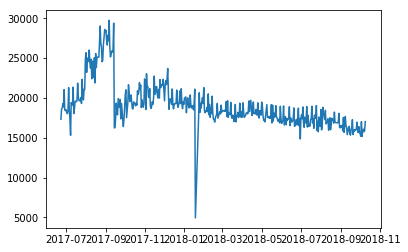

In [80]:
# ggplot(login, aes(x='LoginDate',y='UID')) + geom_point()
import matplotlib.pyplot as plt
plt.plot(group_login.LoginDate, group_login.UID)
plt.show()

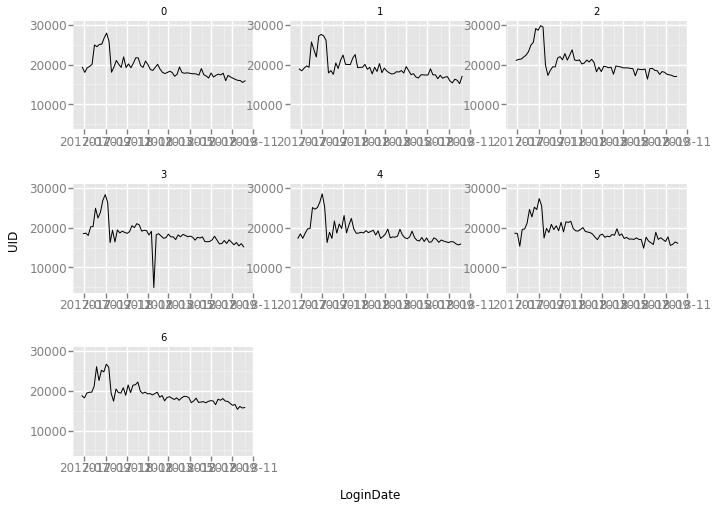

<ggplot: (541312751)>

In [94]:
from ggplot import *
ggplot(group_login, aes(x='LoginDate', y='UID')) + \
    geom_line(colour='blue') + \
    facet_wrap('Weekday') 
''' 
'''

In [35]:
# group user by login time and deposit amount
time_payment.head()

,UID,TransTime,DepositAmount,Weekday,Datetime
0,3352496,2017-01-31 00:42:35,500,1,2017-01-31 00:42:35
1,3352496,2018-02-19 10:53:55,500,0,2018-02-19 10:53:55
2,3458960,2017-07-20 17:57:17,500,3,2017-07-20 17:57:17
3,3458960,2017-08-03 19:05:40,1000,3,2017-08-03 19:05:40
4,3458960,2017-08-25 19:01:55,150,4,2017-08-25 19:01:55


## Group user by login features and deposit amount

In [74]:
# distribution of "hour and minute" of TransTime
def time_interval(time):
    
    time_type = time.hour
    
    if time.minute >30:
        time_type += 1
    else:
        pass
    
    return time_type

# time_series = time_payment.Datetime.apply(time_interval)
time_count = time_series.value_counts().to_frame()
time_count['Hour'] = time_count.index
# time_count
# ggplot(time_count, aes(x='Hour', weight='Datetime')) + geom_bar() # same as the previous time

def time_type(interval):
    
    if 5 < interval < 17: # gr1: 6 ~ 16: working time
        time_type = '1'
    elif 16 < interval < 25: # gr2: 17 ~ 24: first peek 
        time_type = '2'
    else: # gr3: 0 ~ 5: second peek
        time_type = '3'
    
    return time_type

time_payment['TimeType'] = time_payment.TransTime.apply(lambda x: time_type(time_interval(x)))

In [79]:
time_payment.head()

,UID,TransTime,DepositAmount,Weekday,Datetime,TimeType
0,3352496,2017-01-31 00:42:35,500,1,2017-01-31 00:42:35,3
1,3352496,2018-02-19 10:53:55,500,0,2018-02-19 10:53:55,1
2,3458960,2017-07-20 17:57:17,500,3,2017-07-20 17:57:17,2
3,3458960,2017-08-03 19:05:40,1000,3,2017-08-03 19:05:40,2
4,3458960,2017-08-25 19:01:55,150,4,2017-08-25 19:01:55,2


# LightFM

In [92]:
from lightfm import LightFM

In [103]:
from scipy import sparse
from sklearn.model_selection import train_test_split
import pandas as pd
item_pivot = pd.read_csv('/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/ItemUserPivotDF.csv',index_col = 0)

item_pivot_df = item_pivot.fillna(0)
train, test = train_test_split(item_pivot_df, test_size=0.2)
sTrain = sparse.csr_matrix(train)
sTest = sparse.csc_matrix(test)

In [95]:
print(sTrain.shape)
print(train.shape)
train.head()

(40940, 133)
(40940, 133)


,12980,15038,15039,15040,15041,15042,15043,15044,15045,15046,...,52213,52214,52215,52216,52217,52218,52219,52220,52221,52222
UID,,,,,,,,,,,,,,,,,,,,,
3690944,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34745280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33220832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16053024,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45296957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(no_components=30, loss='warp')
model.fit(sTrain, epochs=50)
model

In [100]:
model.predict(user_ids=[range(sTrain.shape[0])], item_ids=range(sTrain.shape[0]))

AssertionError: 

array([ 1.,  2.,  1., ..., 31.,  1.,  1.])

In [18]:
train_precision = precision_at_k(model, sTrain, k=5).mean()
# test_precision = precision_at_k(model, sTest, k=5).mean()

train_auc = auc_score(model, sTrain).mean()
# test_auc = auc_score(model, sTest).mean()

print('Precision of training data: {}'.format(str(train_precision)))
# print('Precision of training data: {}'.format(str(test_precision)))
print('')
print('AUC of training data: {}'.format(str(train_auc)))
# print('AUC of training data: {}'.format(str(test_auc)))

Precision of training data: 0.46590617

AUC of training data: 0.9981741


In [10]:
 item_user_df = sparse.csr_matrix(item_pivot_df.values)
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

full_model = LightFM(no_components=50, loss='warp')
full_model.fit(item_user_df, epochs=100)

train_precision = precision_at_k(full_model, item_user_df, k=5).mean()
train_auc = auc_score(full_model, item_user_df).mean()
print('Precision of training data: {}'.format(str(train_precision)))
print('')
print('AUC of training data: {}'.format(str(train_auc)))

Precision of training data: 0.4704367

AUC of training data: 0.99994993


In [29]:
item_pivot_df.shape

(51175, 133)

In [54]:
# full_model.predict(item_ids=[2,4,5], user_ids=[1])
code_df = pd.DataFrame({'Loc':range(item_pivot_df.shape[0]),'UID':item_pivot_df.index})

user_id = 26258912
user_loc = code_df.loc[code_df.UID == user_id].Loc.values[0]

predict = full_model.predict(item_ids=list(range(item_pivot_df.shape[1])), user_ids=[user_loc])
predict_df = pd.DataFrame({'Loc': range(item_pivot_df.shape[1]), 'Value': predict})
top5_loc = predict_df.sort_values('Value', ascending=False).Loc[:5].tolist()

top5_id = item_pivot_df.columns[top5_loc]
top5_id
# full_model.user_embeddings.shape #(51175, 50)
# full_model.item_embeddings.shape # (133,50)

Index(['15038', '12980', '15042', '15043', '15041'], dtype='object')

In [56]:
list(top5_id)

['15038', '12980', '15042', '15043', '15041']

## Cluster user to get recommend of friend and partner

In [4]:
## Feature 1: similar login time

In [ ]:
''' Total 465 day: 
'''

login['LoginTime'] = 1

login_pivot = login.pivot_table(index='UID', columns='LoginDate', values='LoginTime')
login_pivot = login_pivot.fillna(0) 
login_pivot.head(10)

In [121]:
''' get top 20 people that has the similar login date for a given id
'''

def get_login_recommend(df, user_id):
    ''' look into the past 1 month data
    '''
    from datetime import datetime, timedelta
    # now = datetime.now() # we don't have all data
    now = max(set(login.LoginDate))
    a_month_ago = now - timedelta(days=30)

    # query database to get a month data
    tar_df = login.loc[(login.LoginDate > a_month_ago) & (login.LoginDate < now)]
    # print(tar_df.head(10))
    tar_pivot = tar_df.pivot_table(index='UID', columns='LoginDate', values='LoginTime').fillna(0).astype('int64')
    # compare vector distance
    target = tar_pivot.loc[tar_pivot.index == user_id]
    other = tar_pivot.loc[tar_pivot.index != user_id]

    id_list = []
    dist_list = []

    for index, entry in other.iterrows():
            dist = np.linalg.norm(target.values - entry.values)
            id_list.append(index)
            dist_list.append(dist)
    outcome = pd.DataFrame({'id':id_list , 'dist': dist_list})
    candidate = outcome.loc[outcome.dist==closet_dist].id.tolist()
    
    return candidate
    
get_login_recommend(login, 1290944 )

[1297680,
 1317520,
 1330672,
 1334848,
 1339488,
 1341488,
 1357616,
 1373008,
 1429136,
 1432272,
 1437104,
 1442384,
 1457040,
 1460656,
 1477888,
 1487408,
 1494400,
 1504128,
 1505616,
 1506592,
 1554032,
 1564832,
 1570336,
 1570544,
 1573904,
 1611840,
 1634736,
 1636256,
 1654640,
 1669792,
 1680160,
 1680640,
 1694272,
 1705536,
 1729920,
 1737936,
 1748528,
 1784208,
 1820176,
 1826528,
 1846320,
 1850384,
 1856608,
 1858384,
 1870352,
 1916528,
 1922864,
 1923520,
 1944176,
 1991792,
 1992304,
 2005184,
 2047984,
 2054816,
 2132608,
 2147792,
 2160336,
 2211440,
 2297344,
 2309920,
 2357376,
 2404912,
 2489616,
 2610080,
 2671472,
 2676384,
 2690528,
 2710384,
 2744208,
 2748016,
 2781376,
 2801728,
 2806240,
 2814960,
 2930992,
 2958192,
 2960144,
 2978464,
 2980432,
 2987744,
 3013968,
 3055376,
 3065536,
 3133248,
 3236864,
 3240480,
 3251168,
 3265952,
 3281120,
 3296272,
 3303760,
 3330464,
 3366848,
 3380368,
 3554672,
 3590384,
 3628208,
 3632288,
 3637488,
 3638320,


In [10]:
character.columns
''' Cluster Feature: 'CashAmount', 'P_', '1stRein', '2ndRein','ReinTimes'
'''

Index(['SN', 'ServerNo', 'CharaID', 'UID', 'Career', 'P1', 'P2', 'CashAmount',
       'Popularity', 'Gender', 'SpouseID', 'ReinTimes', 'ReinLevel', '1stRein',
       '2ndRein', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8'],
      dtype='object')

In [11]:
character.ReinTimes.value_counts()

0    4768158
2      33933
1      12659
Name: ReinTimes, dtype: int64

In [15]:
print(character.ReinLevel.value_counts())
print(character['1stRein'].value_counts())
print(character['2ndRein'].value_counts())

0     4770391
10       5013
1        1986
50       1635
51       1219
40       1031
52        999
6         974
2         950
13        919
8         913
9         897
11        874
53        859
54        859
30        841
7         827
21        805
22        801
16        777
25        729
41        729
5         725
15        721
12        696
27        653
17        652
24        649
3         644
26        643
31        636
4         635
29        631
28        609
20        595
14        589
19        588
55        585
32        576
36        568
23        564
18        555
34        544
35        544
48        527
42        527
43        512
47        504
44        488
33        487
46        487
45        475
39        467
37        463
38        458
49        428
56        282
57         12
58          2
60          1
Name: ReinLevel, dtype: int64
0      4768158
101      11892
100      10668
102       9727
103       7672
105       4156
104       2477
Name: 1stRein, dtype: int

In [4]:
tar_col = ['CashAmount', 'P1','P2','P3','P4','P5','P6','P7','P8', '1stRein', '2ndRein','ReinTimes']
chara_clu_df = character[tar_col]
chara_clu_df.head(10)

,CashAmount,P1,P2,P3,P4,P5,P6,P7,P8,1stRein,2ndRein,ReinTimes
21,0,100,6,0,0,0,0,0,0,0,0,0
22,5023405,41,4,0,0,0,0,0,0,0,0,0
23,0,1,0,0,0,0,0,0,0,0,0,0
24,1618,4,0,0,0,0,0,0,0,0,0,0
25,7093,9,0,0,0,0,0,0,0,0,0,0
26,0,1,0,0,0,0,0,0,0,0,0,0
27,13175,67,4,0,0,0,0,0,0,0,0,0
28,23949,23,2,0,0,0,0,0,0,0,0,0
29,5223,33,0,0,0,0,2739,41,691,0,0,0
30,25943,33,0,0,0,0,2739,30,830,0,0,0


In [5]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=5)          # 3次元に圧縮するPCAインスタンスを作成
pca.fit(chara_clu_df.values)
X = pca.fit_transform(chara_clu_df.values)  # wineデータをPCAで次元圧縮
pca_chara = pd.DataFrame(X, index=character.UID.values).iloc[:,:2]                      # 可視化のためにデータフレームに変換
pca_chara.columns = ['dim1', 'dim2']
print(pca.explained_variance_ratio_)
print(pca_chara.head())

[5.65188315e-01 4.34811451e-01 2.17559552e-07 1.39751160e-08
 2.26953591e-09]
                  dim1          dim2
45203061 -1.332333e+06 -1.539390e+06
45203061 -2.104997e+05  3.357149e+06
11374352 -1.332333e+06 -1.539390e+06
29471424 -1.331972e+06 -1.537812e+06
31094496 -1.330749e+06 -1.532476e+06


In [6]:
'''based on id, find the nearest 20 value
'''
import random
# def get_closest_user(user_id, pca_df):
tar_df = pca_chara.loc[pca_chara.index == 45499277]
ran_num = random.sample(range(tar_df.shape[0]), 1)[0]
tar_data = tar_df.iloc[ran_num,:]

In [61]:
def get_friend_feature_recommend(user_id, n):

    tar_col = ['CashAmount', 'P1','P2','P3','P4','P5','P6','P7','P8', '1stRein', '2ndRein','ReinTimes']
    chara_clu_df = character[tar_col]
    
    pca = PCA(n_components=5)  
    pca.fit(chara_clu_df.values)
    X = pca.fit_transform(chara_clu_df.values)
    pca_chara = pd.DataFrame(X, index=character.UID.values).iloc[:,:2]    
    
    print('Start to compute Distance')
    init_dist = []
    init_index = []
    for index, entry in pca_chara.iloc[:,:].iterrows():
        dist = np.linalg.norm(tar_data.values - entry.values)
        init_dist.append(dist)
        init_index.append(index)

    dist_df = pd.DataFrame({'UID': init_index,'Dist': init_dist})
    dist_df = dist_df.loc[dist_df.UID!=user_id,:]
    top_n_df = dist_df.sort_values('Dist').iloc[:n,:]
    top_n = top_n_df.UID.values
    
    return top_n

In [63]:
%time print(get_friend_feature_recommend(45499277))

[14936288  6089248 35752352  1489728 25911136 14826640 33830816  4849744
 13022048 35714288 16757504 21325632 33660560 29878944 27141008  1548224
 35810720 13520240 15601344 32759328  2255200 24538576 16604160 44283648
  2867856 30657952  1397072 30622656 38986880 34668576]
CPU times: user 5min 1s, sys: 21.1 s, total: 5min 22s
Wall time: 5min 35s


In [80]:
type(test_df.Gender.iloc[0])

numpy.int64

In [84]:
# test_list = [14936288, 6089248]
# test_df = character.iloc[:1000,:]
# for index, entry in test_df.iterrows():
#     if 
character.loc[(character.UID.apply(lambda x: x in test_list)) & (character.Gender != 1)]

,SN,ServerNo,CharaID,UID,Career,P1,P2,CashAmount,Popularity,Gender,...,ReinTimes,ReinLevel,1stRein,2ndRein,P3,P4,P5,P6,P7,P8
652875,"652897,652899",1,14936288,14936288,0,101,31,29411946,15460,0,...,0,0,0,0,0,0,0,0,0,0
2671032,"2671054,2671056",3,14936288,14936288,0,19,2,17143,107,0,...,0,0,0,0,0,0,0,0,0,0
2671033,"2671055,2671057",3,14936289,14936288,0,1,0,33,0,0,...,0,0,0,0,0,0,0,0,0,0
4370579,"4370601,4370603",4,14936288,14936288,6,4,0,1058,3,0,...,0,0,0,0,0,0,0,0,0,0


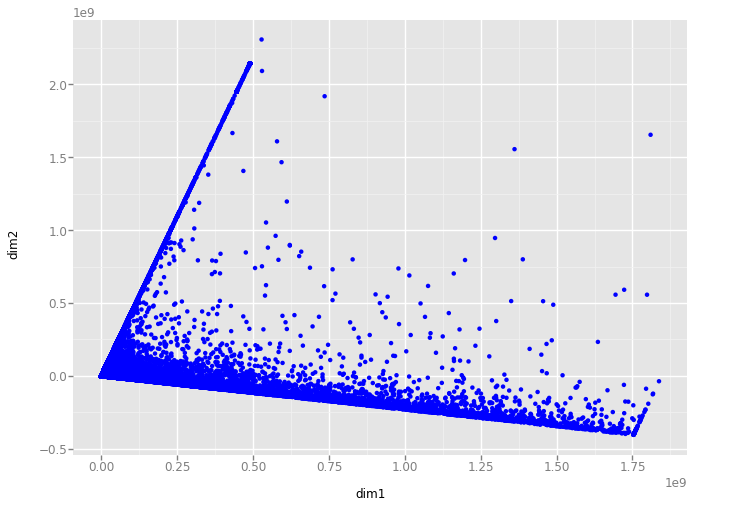

<ggplot: (379912042)>

In [248]:
from ggplot import *
ggplot(pca_chara, aes(x='dim1',y='dim2')) + geom_point(color='blue')

# RFME

In [85]:
''' Recency, Frequency, Monetary
'''
time_payment.head()

,UID,TransTime,DepositAmount,TransDate,Weekday
0,3352496,2017-01-31 00:42:35,500,2017-01-31,1
1,3352496,2018-02-19 10:53:55,500,2018-02-19,0
2,3458960,2017-07-20 17:57:17,500,2017-07-20,3
3,3458960,2017-08-03 19:05:40,1000,2017-08-03,3
4,3458960,2017-08-25 19:01:55,150,2017-08-25,4


In [68]:
''' Engagement
'''
login.head()

,UID,LoginDate,Weekday
0,42954752,2018-04-16,0
1,45436584,2018-04-16,0
2,5041824,2018-04-16,0
3,45436382,2018-04-16,0
4,13871120,2018-04-16,0


In [101]:
''' Recency: find the last day and see the deposit distribution of 
'''
latest = time_payment.TransDate.sort_values(ascending=False)[40254] # 2018/10/10
# find the latest day for each UID
latest_deposit = time_payment.groupby('UID').agg('max')
time_diff = latest_deposit.TransDate.apply(lambda datetime: datetime - latest)

In [102]:
latest

Timestamp('2018-10-10 00:00:00')

<BarContainer object of 644 artists>

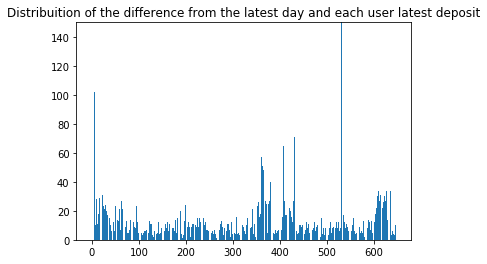

In [110]:
%matplotlib inline
diff_count = time_diff.value_counts()
diff_df = pd.DataFrame({'Diff':-(diff_count.index.days), "Value": diff_count.values})
k
plt.ylim(0, 150)
plt.title('Distribuition of the difference from the latest day and each user latest deposit')
plt.bar(diff_df.Diff, diff_df.Value)

# conclusion: take 300days at the boundary for recency

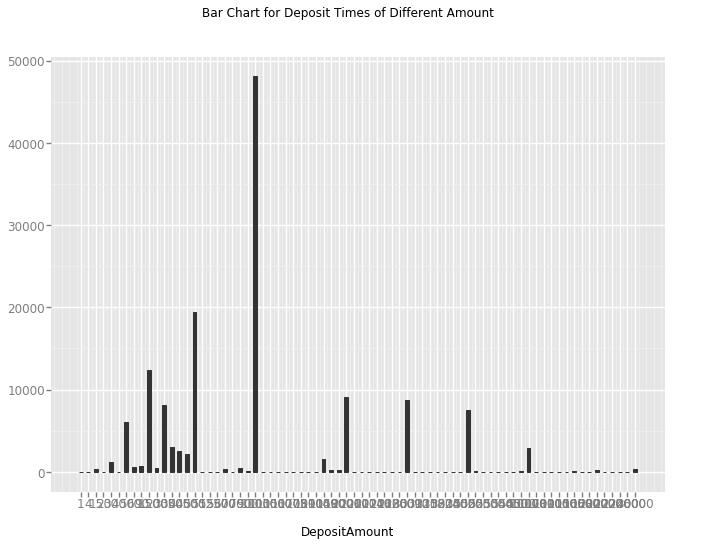

<ggplot: (-9223372036524693728)>

In [120]:
''' Monetary
'''
# print(time_payment.DepositAmount.value_counts(ascending=False))
ggplot(time_payment, aes('DepositAmount')) + geom_bar(width=0.5) + ggtitle('Bar Chart for Deposit Times of Different Amount')

In [124]:
''' Frequency
'''
first_deposit = time_payment.iloc[:,:2].groupby('UID').agg('min')
last_deposit = time_payment.iloc[:,:2].groupby('UID').agg('max')

deposit_diff = (last_deposit - first_deposit).TransTime.apply(lambda x: x.days)
time_payment['DepositValue'] = np.ones(time_payment.shape[0])
user_total_deposit_time = time_payment.iloc[:,:].groupby('UID').agg('sum').iloc[:,:]
# user_total_deposit_time['AvgDeposit'] = 
user_total_deposit_time['avg'] = user_total_deposit_time.DepositValue / deposit_diff

In [128]:
avg_list = []
for index, entry in user_total_deposit_time.iterrows():
    if entry.avg > 1:
        avg_list.append(0)
    else:
        avg_list.append(entry.avg)
        
user_total_deposit_time['AvgDeposit'] = avg_list

In [143]:
avg_df = user_total_deposit_time.AvgDeposit.value_counts()
avg_df = pd.DataFrame({'Count': avg_df.values, 'Frequency':avg_df.index})
# avg_df['AvgTIme'] = 
# avg_df.values
# plt.ylim(0, 100)
# plt.xlim(, 1)
# plt.scatter(avg_df.index, avg_df.values)

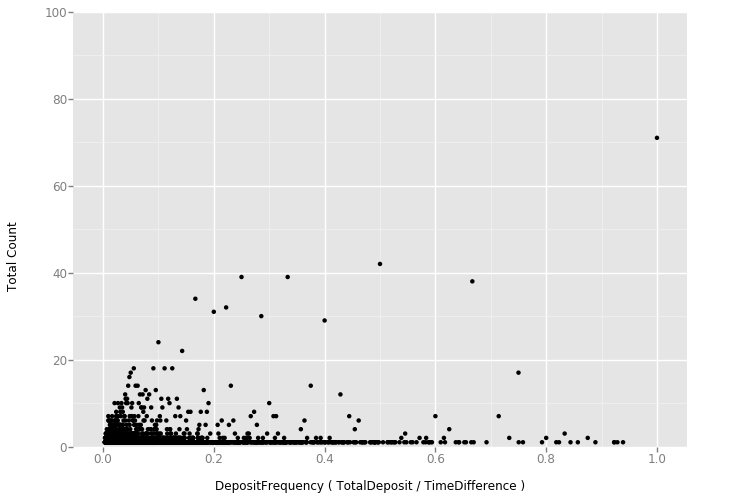

<ggplot: (367871166)>

In [149]:
''' Conclusion: if AvgDep >= 0.5
'''
# avg_value_count = user_login_total_latest.AvgLogin.value_counts()
# ggplot(user_total_deposit_time, aes('AvgDeposit')) + geom_density() + ggtitle('Density Plot for Average Deposit Time')
ggplot(avg_df, aes(x='Frequency', y='Count')) + geom_point() +ylim(0,100) + xlab('DepositFrequency ( TotalDeposit / TimeDifference )') + ylab('Total Count')

In [149]:
''' Engagement: average login time from the user's first record to the global latest login record
'''
each_user_first_login = login.iloc[:,:2].groupby('UID').agg('min')
each_user_last_login = login.iloc[:,:2].groupby('UID').agg('max')

each_user_diff = (each_user_last_login - each_user_first_login)
each_user_diff = each_user_diff.LoginDate.apply(lambda x: x.days)

login['LoginValue'] = np.ones(login.shape[0])
each_user_total_login_time = login.iloc[:,:].groupby('UID').agg('sum').iloc[:,-1]

In [150]:
user_login_total_latest = pd.DataFrame({'TimeDifference':each_user_diff.values,
                                        'TotalLogin':each_user_total_login_time.values}, index= each_user_diff.index)

In [164]:
# user_login_total_latest['avg'] = user_login_total_latest.TotalLogin / user_login_total_latest.TimeDifference 
avg_list = []
for index, entry in user_login_total_latest.iterrows():
    if entry.avg > 1:
        avg_list.append(0)
    else:
        avg_list.append(entry.avg)

In [165]:
user_login_total_latest['AvgLogin'] = avg_list 

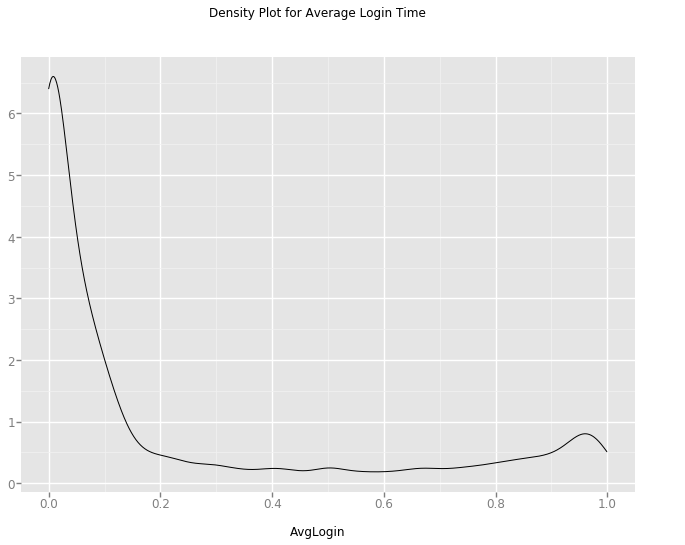

<ggplot: (370577977)>

In [174]:
''' Conclusion: if AvgLogin > 0.6
'''
# avg_value_count = user_login_total_latest.AvgLogin.value_counts()
ggplot(user_login_total_latest, aes('AvgLogin')) + geom_density() + ggtitle('Density Plot for Average Login Time')

In [275]:
''' Total RFME distribution for common 6704 user in 4 dataset
'''
rfm_df = pd.DataFrame({
    'RFMCate': ['非課金', '路人', '忙碌', '新人', '活動型','潛力','一般玩家','一般挽回',
                '停滯','土豪','一般維持','深耕','收集', '重要', '換回', '重點挽回'] , 
    'Count': [1363, 879, 820, 785, 733, 547, 411, 288, 207, 179, 158, 141, 80, 53, 33, 26]})
rfm_df['Proportion'] = (rfm_df.Count)/6704
rfm_df

,RFMCate,Count,Proportion
0,非課金,1363,0.203311
1,路人,879,0.131116
2,忙碌,820,0.122315
3,新人,785,0.117094
4,活動型,733,0.109338
5,潛力,547,0.081593
6,一般玩家,411,0.061307
7,一般挽回,288,0.042959
8,停滯,207,0.030877
9,土豪,179,0.026700


### Find user that have data in all data set

In [89]:
login_user = set(login.UID)
print(len(login_user))
deposit_user = set(time_payment.UID)
print(len(deposit_user))
character_user = set(character.UID)
print(len(character_user))
item_server_user = set(item_server.UID)
print(len(item_server_user))

207628
9389
1955330
51175


In [168]:
all_common_user = login_user & deposit_user & character_user & item_server_user

In [107]:
all_common_user = pd.read_csv(
    '/Users/hsnu130427/BigdataCourse/20181010NCCU_BDcourse_Project/FourDatasetCommonUser.txt')

## Item recommend part

In [19]:
pivot = item_pivot

In [51]:
item_train = item_pivot.transpose().fillna(0)
train = sparse.csc_matrix(item_train)

model = LightFM(no_components=30, loss='warp')
# logging.info('Start to train recommend model.')
model.fit(train, epochs=50)
prediction = precision_at_k(model, train, k=5)      
# train_auc = auc_score(model, train).mean()
print('Finish training with precision {} and'.format(prediction.mean()))
# print(prediction)

Finish training with precision 0.8195488452911377 and


In [36]:
item_id = 52216

code_df = pd.DataFrame({'Loc':range(pivot.shape[1]),'UID': pd.Series(pivot.columns).apply(lambda x: int(x))})
code_df
item_loc = code_df.loc[code_df.UID == item_id].Loc.values[0]

In [47]:
predict = model.predict(item_ids=list(range(pivot.shape[0])), user_ids=[item_loc])
predict_df = pd.DataFrame({'Loc': range(pivot.shape[0]), 'Value': predict})

In [ ]:
n=5
top5_loc = predict_df.sort_values('Value', ascending=False).Loc[:n].tolist()

top_5_user = list(pivot.index[top5_loc])
top_5_user

# Assoication Rule

In [54]:
''' Separate into several day and make pivot table, then group together
'''
item_server.head()

,UID,RecordTime,ItemID,ItemNum,ServerNo,ItemType,SetType
0,45499277,2018-09-03 06:30:00.000,52216,1,4,TypeA,None
1,45499285,2018-09-03 06:30:00.000,41815,1,4,TypeB,None
2,45499287,2018-09-03 06:30:00.000,39872,1,4,TypeE,None
3,45499287,2018-09-03 06:30:00.000,41802,1,4,TypeB,SetC
4,45499287,2018-09-03 06:30:00.000,41819,1,4,TypeB,None


In [4]:
''' Required data type for association rule
'''
item_asso = item_server.groupby(['UID', 'RecordTime'])['ItemID'].apply(list)
item_record = []
for i in item_asso:
    item_record.append(i)

In [114]:
item_record

[[15039],
 [15039],
 [15039],
 [12980],
 [12980],
 [12980],
 [12980, 15039, 15040, 15041, 15043, 21377],
 [12980, 15039, 15040, 15041, 15043, 21377],
 [12980, 15039, 15040, 15041, 15043, 21377],
 [12980],
 [12980],
 [12980],
 [12980, 15038, 15039, 15040, 15043],
 [12980, 15038, 15039, 15040, 15043],
 [12980, 15038, 15039, 15040, 15043],
 [12980, 15038, 15043, 15046],
 [12980, 15038, 15043, 15046],
 [12980, 15038, 15043, 15046],
 [15038],
 [15038],
 [15038],
 [12980, 15038, 15039, 15040, 15042],
 [12980, 15038, 15039, 15040, 15042],
 [12980, 15038, 15039, 15040, 15042],
 [12980, 15039, 15040],
 [12980, 15039, 15040],
 [12980, 15039, 15040],
 [15039],
 [15039],
 [15039],
 [12980, 15038, 15039, 15046],
 [12980, 15038, 15039, 15046],
 [12980, 15038, 15039, 15046],
 [15038, 15042, 15043],
 [15038, 15042, 15043],
 [15038, 15042, 15043],
 [15039, 15040],
 [15039, 15040],
 [15039, 15040],
 [15038, 15039, 15040],
 [15038, 15039, 15040],
 [15038, 15039, 15040],
 [12980, 15038, 15039],
 [12980, 1

In [90]:
len(item_record)

153081

In [76]:
''' Type 1 association rule: 
'''
# from apyori import apriori
# association_rules = apriori(item_record, min_support=0.01, min_confidence=0.2, min_lift=3, min_length=2)  
# association_results = list(association_rules)  # total 44274 rules

df_list = []
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
    df_list.append([items, item[1], item[2][0][2], item[2][0][3]])
    
assco_df = pd.DataFrame(df_list, columns = ['ItemSet', 'Support', 'Confidence', 'Lift']) # total 44000 entry
assco_df.to_csv('/Users/hsnu130427/BigdataCourse/Recommender/association_rules.csv')

In [36]:
assco_df = pd.read_csv('/Users/hsnu130427/BigdataCourse/Recommender/association_rules.csv').iloc[:,1:]

In [78]:
item_id = 52195
assco_df

,ItemSet,Support,Confidence,Lift
0,"[15040, 15039]",0.064482,0.385691,3.225107
1,"[15041, 15039]",0.027881,0.547039,3.272040
2,"[15043, 15039]",0.013686,0.546997,3.271789
3,"[15040, 15041]",0.025072,0.209647,4.113421
4,"[15040, 15042]",0.018872,0.410253,3.430486
5,"[15040, 15043]",0.011765,0.470235,3.932050
6,"[15041, 15042]",0.014659,0.287619,6.252334
7,"[21377, 21378]",0.012895,0.296218,7.703945
8,"[39872, 36673]",0.017180,0.737108,3.887720
9,"[36673, 50247]",0.010315,0.442545,12.193162


In [ ]:
# groupby "From" and "To"
group_assco = tar_df.groupby(['From', 'To']).agg('max')

#
group_assco.loc[group_assco.From == item_id].sort_values('Support', ascending=False).iloc[:5, ]
#

In [73]:
for item in association_results[40000:41000]:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print('Items: ' )
    print(items)
    print("Rule: " + str(items[0]) + " -> " + str(items[1]))

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list
    
    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Items: 
[52196, 50251, 52205, 47376, 50257, 52176, 50259, 52216, 52186]
Rule: 52196 -> 50251
Support: 0.013162966011457986
Confidence: 0.9724903474903474
Lift: 10.483050129157796
Items: 
[52196, 50251, 52206, 47376, 50257, 52176, 50259, 52215, 52186]
Rule: 52196 -> 50251
Support: 0.01312377107544372
Confidence: 0.7592592592592593
Lift: 16.596910847731927
Items: 
[52196, 50251, 52206, 47376, 50257, 52176, 50259, 52216, 52186]
Rule: 52196 -> 50251
Support: 0.016540262998020656
Confidence: 0.9569160997732427
Lift: 10.315166077697892
Items: 
[52196, 50251, 47376, 50257, 52176, 50259, 52215, 52216, 52186]
Rule: 52196 -> 50251
Support: 0.013025783735408051
Confidence: 0.9665535627726611
Lift: 10.419054006253203
Items: 
[50251, 52205, 52206, 47376, 50257, 52176, 50259, 52215, 52186]
Rule: 50251 -> 52205
Support: 0.012437859695194047
Confidence: 0.9193626267503621
Lift: 20.09666575261633
Items: 
[50251, 52205, 52206, 47376, 50257, 52176, 50259, 52216, 52186]
Rule: 50251 -> 52205
Support: 0.013

Confidence: 0.9694966954753432
Lift: 21.192563706991436
Items: 
[52195, 52196, 50251, 52205, 47376, 50257, 52216, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.012463989652536893
Confidence: 0.9700050838840876
Lift: 10.45625999901838
Items: 
[52195, 52196, 50251, 52206, 47376, 50257, 52215, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.01256197699257256
Confidence: 0.9605394605394605
Lift: 20.99676440937329
Items: 
[52195, 52196, 50251, 52206, 47376, 50257, 52216, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.012738354204636761
Confidence: 0.974025974025974
Lift: 10.499603558190982
Items: 
[52195, 52196, 50251, 47376, 50257, 52215, 52216, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.012470522141872603
Confidence: 0.9656044511886697
Lift: 10.40882296967909
Items: 
[52195, 50251, 52205, 52206, 47376, 50257, 52215, 52185, 52186]
Rule: 52195 -> 50251
Support: 0.012457457163201182
Confidence: 0.971967380224261
Lift: 21.246571259761545
Items: 
[52195, 50251, 52205, 52206, 47376, 50257, 5221

Lift: 10.36521158145528
Items: 
[52195, 50251, 52205, 52206, 47376, 50259, 52215, 52185, 52186]
Rule: 52195 -> 50251
Support: 0.012006715399037112
Confidence: 0.9714587737843553
Lift: 21.23545345561658
Items: 
[52195, 50251, 52205, 52206, 47376, 50259, 52216, 52185, 52186]
Rule: 52195 -> 50251
Support: 0.011987117931029977
Confidence: 0.9698731501057083
Lift: 10.454837806586292
Items: 
[52195, 50251, 52205, 47376, 50259, 52215, 52216, 52185, 52186]
Rule: 52195 -> 50251
Support: 0.011928325527008577
Confidence: 0.9530271398747391
Lift: 10.273244672851556
Items: 
[52195, 50251, 52206, 47376, 50259, 52215, 52216, 52185, 52186]
Rule: 52195 -> 50251
Support: 0.011980585441694266
Confidence: 0.9683210137275606
Lift: 10.43810640817046
Items: 
[52196, 50251, 52205, 52206, 47376, 50259, 52215, 52185, 52186]
Rule: 52196 -> 50251
Support: 0.012137365185751335
Confidence: 0.9533093894304772
Lift: 20.83871978343665
Items: 
[52196, 50251, 52205, 52206, 47376, 50259, 52216, 52185, 52186]
Rule: 52196 

Items: 
[52195, 52196, 52175, 47376, 50257, 50259, 52215, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.011928325527008577
Confidence: 0.9702444208289055
Lift: 21.208908494203868
Items: 
[52195, 52196, 52175, 47376, 50257, 50259, 52216, 52185, 52186]
Rule: 52195 -> 52196
Support: 0.011856468144315754
Confidence: 0.9643995749202975
Lift: 10.395834893907054
Items: 
[52195, 52205, 52206, 52175, 47376, 50257, 50259, 52185, 52186]
Rule: 52195 -> 52205
Support: 0.011843403165644332
Confidence: 0.955719557195572
Lift: 10.074542455244137
Items: 
[52195, 52205, 52175, 47376, 50257, 50259, 52215, 52185, 52186]
Rule: 52195 -> 52205
Support: 0.012098170249737068
Confidence: 0.9762783342119137
Lift: 21.34080589454433
Items: 
[52195, 52205, 52175, 47376, 50257, 50259, 52216, 52185, 52186]
Rule: 52195 -> 52205
Support: 0.011804208229630065
Confidence: 0.9525566684238271
Lift: 10.268173182099
Items: 
[52195, 52206, 52175, 47376, 50257, 50259, 52215, 52185, 52186]
Rule: 52195 -> 52206
Support: 0.011869

[52196, 52205, 52206, 52175, 47376, 50257, 52215, 52216, 52185]
Rule: 52196 -> 52205
Support: 0.01228107995113698
Confidence: 0.9720785935884177
Lift: 10.47861158968443
Items: 
[52195, 52196, 52205, 52206, 52175, 47376, 50257, 52215, 52186]
Rule: 52195 -> 52196
Support: 0.01228107995113698
Confidence: 0.9735888140859659
Lift: 21.28201474355187
Items: 
[52195, 52196, 52205, 52206, 52175, 47376, 50257, 52216, 52186]
Rule: 52195 -> 52196
Support: 0.012320274887151247
Confidence: 0.9766960124287934
Lift: 10.528385485431459
Items: 
[52195, 52196, 52205, 52175, 47376, 50257, 52215, 52216, 52186]
Rule: 52195 -> 52196
Support: 0.012183092611101313
Confidence: 0.9688311688311689
Lift: 10.443605672547298
Items: 
[52195, 52196, 52206, 52175, 47376, 50257, 52215, 52216, 52186]
Rule: 52195 -> 52196
Support: 0.01239866475917978
Confidence: 0.9763374485596708
Lift: 10.524520312862682
Items: 
[52195, 52205, 52206, 52175, 47376, 50257, 52215, 52216, 52186]
Rule: 52195 -> 52205
Support: 0.01217002763242

In [65]:
""" Type 2 association
"""
%time outcome_01 = apriori(df, min_support=0.01, use_colnames=True)
outcome_01

CPU times: user 30min 32s, sys: 15.8 s, total: 30min 48s
Wall time: 32min 38s


,support,itemsets
0,0.212417,(12980)
1,0.340604,(15038)
2,0.167186,(15039)
3,0.119590,(15040)
4,0.050966,(15041)
5,0.046002,(15042)
6,0.025019,(15043)
7,0.010263,(15044)
8,0.043533,(21377)
9,0.038450,(21378)


In [56]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

te = TransactionEncoder()
te_ary = te.fit(item_record).transform(item_record)
df = pd.DataFrame(te_ary, columns=te.columns_)
outcome = apriori(df, min_support=0.03, use_colnames=True)
outcome

,support,itemsets
0,0.212417,(12980)
1,0.340604,(15038)
2,0.167186,(15039)
3,0.119590,(15040)
4,0.050966,(15041)
5,0.046002,(15042)
6,0.043533,(21377)
7,0.038450,(21378)
8,0.189599,(39872)
9,0.273411,(47376)


In [64]:
from mlxtend.frequent_patterns import association_rules

association_rules(outcome, metric="confidence", min_threshold=0.7)
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))

frozenset({12980})

In [156]:
''' groupby ItemID -> 
'''
item_server['ServerNo'] = item_server.ServerNo.apply(lambda x: str(x))
item_server.head()

,UID,RecordTime,ItemID,ItemNum,ServerNo,ItemType,SetType
0,45499277,2018-09-03 06:30:00.000,52216,1,4,TypeA,None
1,45499285,2018-09-03 06:30:00.000,41815,1,4,TypeB,None
2,45499287,2018-09-03 06:30:00.000,39872,1,4,TypeE,None
3,45499287,2018-09-03 06:30:00.000,41802,1,4,TypeB,SetC
4,45499287,2018-09-03 06:30:00.000,41819,1,4,TypeB,None


In [164]:
item_num = item_server.groupby('ItemID').agg('sum').ItemNum
item_num.head(10)

ItemID
12980    2499176
15038    1203404
15039     135227
15040      46901
15041      12331
15042      14647
15043       6660
15044       1718
15045       1576
15046       2218
Name: ItemNum, dtype: int64

In [173]:
item_clu_stat = item_server.groupby(['ItemID', 'ServerNo']).size().unstack(level=-1).fillna(0).astype(int)
item_clu_stat['PurchasedRec'] = item_num.values
item_clu_stat.columns = ['Ser1', 'Ser2', 'Ser3', 'Ser4', 'PurRec']
item_clu_stat.head()
# item_clu_stat

,Ser1,Ser2,Ser3,Ser4,PurRec
ItemID,,,,,
12980,6149,7256,13478,6525,2499176
15038,8250,12863,22278,10382,1203404
15039,4018,5978,11036,4895,135227
15040,2938,4394,7741,3478,46901
15041,1363,1827,3220,1446,12331


In [248]:
tar_df = item_clu_stat.loc[item_clu_stat.index == 12980]
pur_rec = tar_df.PurRec.values[0]
top_server = tar_df.iloc[:, :-1].idxmax(axis=1).values[0][-1]
purchase_rank_serie = (item_clu_stat.PurRec.rank(ascending=False).apply(lambda x: int(x)))
rank = purchase_rank_serie.loc[purchase_rank_serie.index == 12980].values[0]

print(pur_rec)
print(top_server)
print(rank)

2499176
3
5


In [247]:
purchase_rank_serie = (item_clu_stat.PurRec.rank(ascending=False).apply(lambda x: int(x)))
rank = purchase_rank_serie.loc[purchase_rank_serie.index == 12980].values[0]
rank

5

In [180]:
item_clu_stat.to_csv('/Users/hsnu130427/BigdataCourse/Recommender/templates/item_server_statistics.csv')

In [259]:
# item_stat = pd.read_csv('/Users/hsnu130427/BigdataCourse/Recommender/item_server_statistics.csv')
item_stat.index = item_stat.ItemID
# item_stat.head()
# item_stat.ItemID[]
tar_df = item_stat.loc[item_stat.ItemID == 12980]
print(tar_df)
pur_rec = tar_df.PurRec.values[0]
print(pur_rec)
top_server = tar_df.iloc[:, :-1].idxmax(axis=1).values[0][-1]
print(top_server)
purchase_rank_serie = (item_stat.PurRec.rank(ascending=False).apply(lambda x: int(x)))
rank = purchase_rank_serie.loc[purchase_rank_serie.index == 12980].values[0]
print(rank)

        ItemID  Ser1  Ser2   Ser3  Ser4   PurRec
ItemID                                          
12980    12980  6149  7256  13478  6525  2499176
2499176
3
5


In [261]:
len(item_stat.index)

133

8461958
3


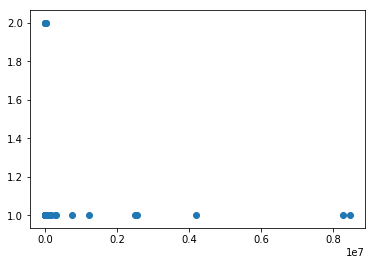

In [214]:
%matplotlib inline
tmp = item_clu_stat.PurRec.value_counts().to_frame()
tmp['PurCount'] = tmp.index
print(max(tmp.PurCount))
print(min(tmp.PurCount))
# plt.xlim(0, 900000)
plt.scatter(tmp.PurCount, tmp.PurRec) 

In [277]:
''' New function: show each sale record in every server for item
'''
item_stat = pd.read_csv('/Users/hsnu130427/BigdataCourse/Recommender/precomputed_data/item_server_statistics.csv')
item_id = 52196

In [357]:
sales_rate = (item_server.loc[item_server.ItemID==item_id].groupby(
                            ['ItemID','RecordTime', 'ServerNo']).agg('sum').unstack().iloc[:, -4:])
server_stat = list(sales_rate.iloc[-1,:].values)
server_stat.append(sum(server_stat))
sales_rate = list(sales_rate.iloc[-2:,:].apply(lambda x: ((x[1] - x[0])/x[0])*100))
sales_rate.append(sum(sales_rate) / 4)
sales_rate = [str(round(rate, 2)) + '%' for rate in sales_rate]
print(server_stat)
print(sales_rate)

[5447, 7802, 9536, 5151, 27936]
['-22.69%', '4.47%', '2.96%', '3.29%', '-2.99%']


In [299]:
list(item_stat.loc[item_stat.ItemID==item_id].values[0])

[52196, 3212, 4446, 6371, 3214, 84544]

# DAU, MAU, Retention, Chrour(1-Retention)

In [415]:
''' DAU, MAU: focus on character and login data
'''

' DAU, MAU: focus on character and login data\n'

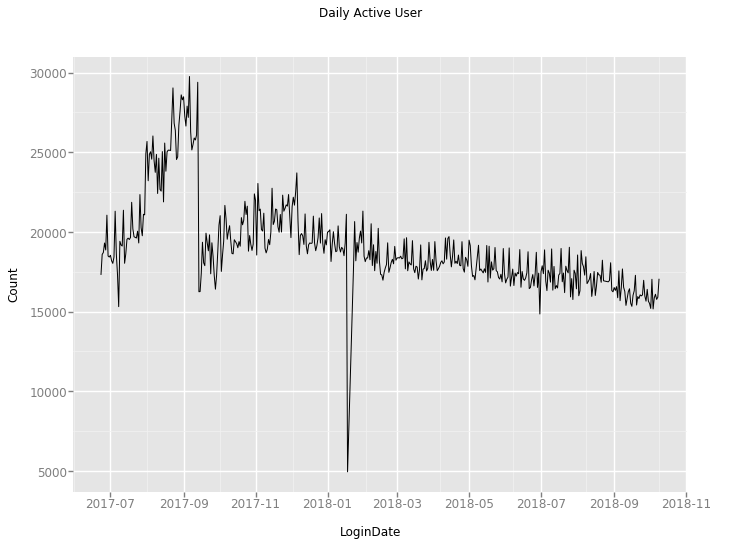

<ggplot: (369856688)>

In [369]:
login_df = login.groupby(['LoginDate']).agg('count').iloc[:, 0]
login_df = pd.DataFrame({'LoginDate': login_df.index, 'Count': login_df.values})

ggplot(login_df, aes(x='LoginDate', y='Count')) + geom_line() + ggtitle('Daily Active User')

In [407]:
login['DateStr'] = login.LoginDate.apply(lambda x: str(x.year) + '/' + str(x.month))

In [409]:
month_count = login.groupby('DateStr').agg('count')
month_count_df = pd.DataFrame({'MonthDate': month_count.index , 'Count': month_count.UID.values})

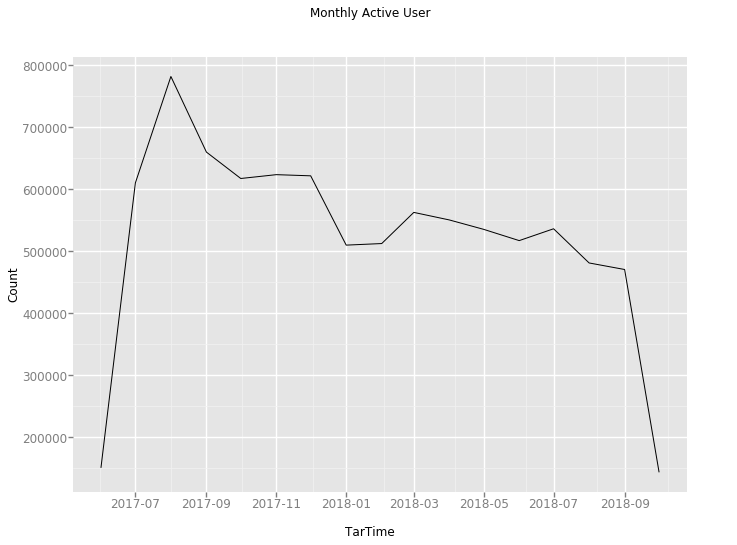

<ggplot: (-9223372036481048583)>

In [414]:
month_count_df['TarTime'] = month_count_df.MonthDate.apply(lambda x: datetime.strptime(x, '%Y/%m'))
ggplot(month_count_df, aes(x='TarTime', y='Count')) + geom_line() +ggtitle('Monthly Active User')

In [470]:
arpu_df.to_csv('/Users/hsnu130427/BigdataCourse/Recommender/precomputed_data/arpu_df.csv')

In [460]:
''' ARPU = total revenue / # of player per day
'''
# login_first = min(login.LoginDate)
# login_last = max(login.LoginDate)
# sel_payment = time_payment.loc[time_payment.TransDate.apply(lambda x: x >= login_first)]
# sel_payment = sel_payment.loc[sel_payment.TransDate.apply(lambda x: x <= login_last)]

# daily_revenue = sel_payment.groupby('TransDate').agg(['sum', 'count']).iloc[:, 2:4] # longer than login people
# LoginPeople =  login.groupby(['LoginDate']).agg('count').iloc[:, 0]
common_date = set(daily_revenue.index) & set(LoginPeople.index)

fil_daily = daily_revenue[list(map(lambda x: x in common_date, daily_revenue.index))]
fil_login = LoginPeople[list(map(lambda x: x in common_date, LoginPeople.index))]

arpu_df = pd.DataFrame({'Date': fil_daily.index,
                        'DepositAmount': fil_daily.iloc[:,0].values, 
                        'LoginPeople': fil_login.values,
                        'DepositPeople': fil_daily.iloc[:, 1].values})
arpu_df

,Date,DepositAmount,LoginPeople,DepositPeople
0,2017-06-23,268650,17335,198
1,2017-06-24,417680,18589,209
2,2017-06-25,315510,18713,231
3,2017-06-26,217225,19306,168
4,2017-06-27,356760,18869,256
5,2017-06-28,210960,21053,139
6,2017-06-29,83210,18491,94
7,2017-06-30,126400,18426,108
8,2017-07-01,210430,18536,196
9,2017-07-02,146250,18189,143


In [461]:
arpu_df['ARPU'] = (arpu_df.DepositAmount)/(arpu_df.LoginPeople)
arpu_df['ARPPU'] = (arpu_df.DepositAmount)/(arpu_df.DepositPeople)
arpu_df['ConversionRate'] = (arpu_df.ARPU)/(arpu_df.ARPPU)

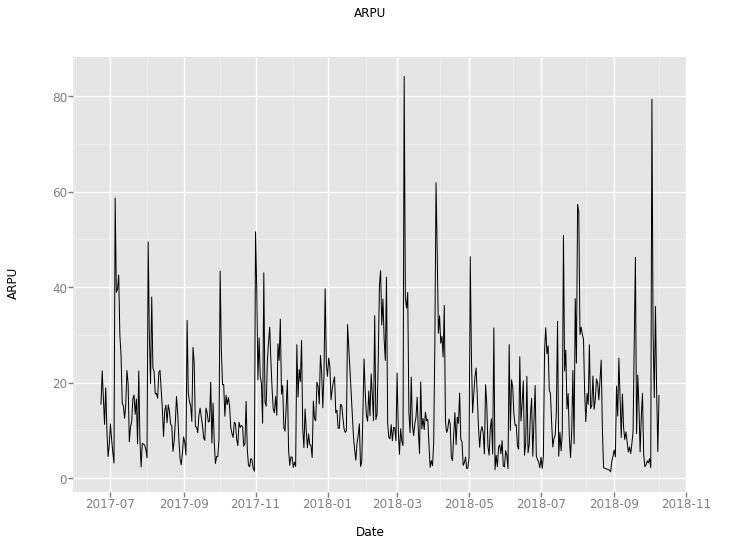

<ggplot: (-9223372036327904126)>

In [465]:
ggplot(arpu_df, aes(x='Date',y='ARPU')) + geom_line() + ggtitle('ARPU')

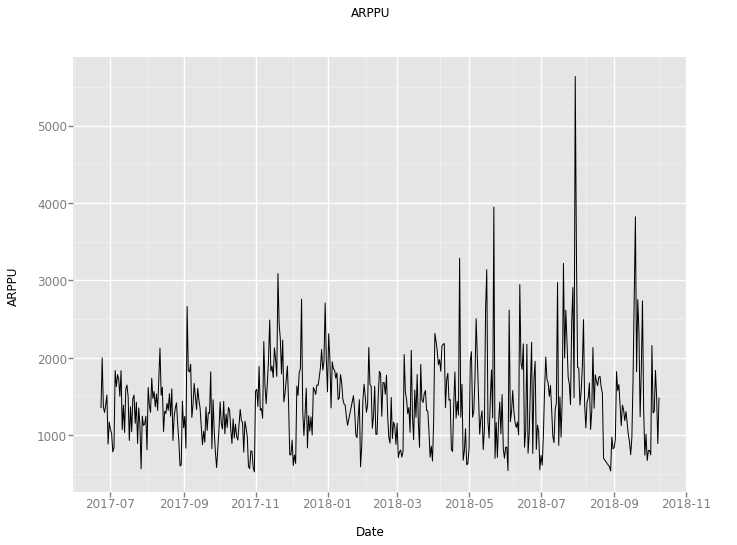

<ggplot: (372274650)>

In [469]:
ggplot(arpu_df, aes(x='Date',y='ARPPU')) + geom_line() + ggtitle('ARPPU')

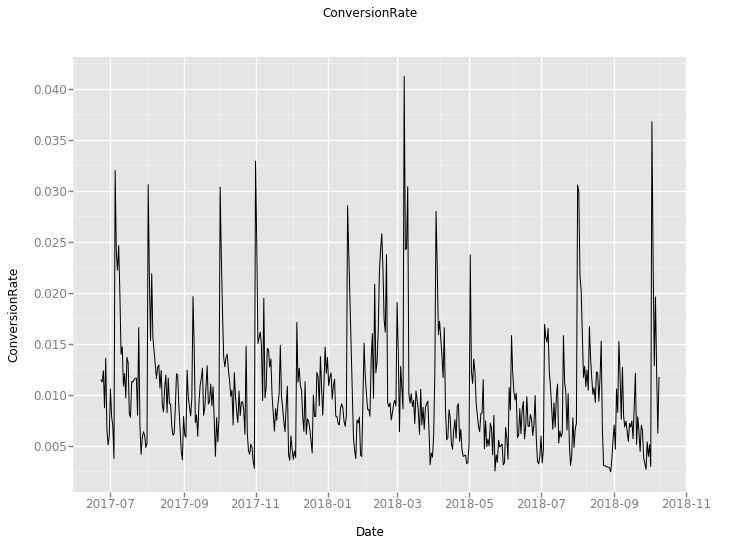

<ggplot: (-9223372036483164707)>

In [468]:
ggplot(arpu_df, aes(x='Date',y='ConversionRate')) + geom_line() + ggtitle('ConversionRate')

In [479]:
''' Retention
'''
item_time = list(set(item_server.RecordTime))
aug_27 = item_server.loc[item_server.RecordTime == item_time[2]]
sep_3 = item_server.loc[item_server.RecordTime == item_time[0]]
sep_17 = item_server.loc[item_server.RecordTime == item_time[0]]

In [499]:
a27u = set(aug_27.UID)
s3u = set(sep_3.UID)
s17u = set(sep_17.UID)

r1n_c1n = list(a27u)
r2n_c1n = [uid for uid in s3u if uid not in r1n_c1n] 
r3n_c1n = [uid for uid in s17u if uid not in r2n_c1n]

r1o_c2n = [uid for uid in s3u if uid in r1n_c1n]
r2o_c2o = [uid for uid in s17u if uid in r2n_c1n]

r1o_c3n = [uid for uid in s17u if uid in r1o_c2n]

In [504]:
rate_11 = 1.0
rate_21 = 1.0
rate_31 = 1.0

rate_12 = len(r1o_c2n) / len(r1n_c1n)
rate_22 = len(r2o_c2o)/ len(r2n_c1n)

rate_13 = len(r1o_c3n)/len(r1n_c1n)

In [503]:
len(r2n_c1n)

169

In [505]:
print('第一期客戶在t=1,2,3的留存率為： {}/{}/{} '.format(rate_11, rate_12, rate_13))
print('第二期客戶在t=2,3(他們的第1, 2 月)的留存率為: {}/{}'.format(rate_21, rate_22))
print('第三期客戶在t=3(他們的第1個月)的留存率為: {}'.format(rate_31))

第一期客戶在t=1,2,3的留存率為： 1.0/0.9988425471809158/0.9988425471809158 
第二期客戶在t=2,3(他們的第1, 2 月)的留存率為: 1.0/1.0
第三期客戶在t=3(他們的第1個月)的留存率為: 1.0


## Plot to html

AttributeError: 'list' object has no attribute 'canvas'

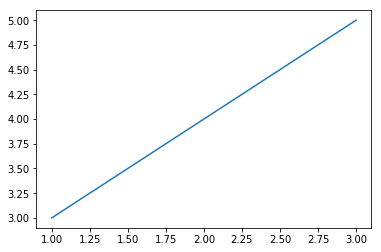

In [52]:
%matplotlib inline
import mpld3
fig = plt.plot([1,2,3],[3,4,5])
plot = mpld3.fig_to_html(fig)

  Using cached https://files.pythonhosted.org/packages/91/95/a52d3a83d0a29ba0d6898f6727e9858fe7a43f6c2ce81a5fe7e05f0f4912/mpld3-0.3.tar.gz
  Running setup.py bdist_wheel for mpld3 ... done
  Stored in directory: /Users/hsnu130427/Library/Caches/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3
mxnet 1.1.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.15.4 which is incompatible.
mxnet 1.1.0.post0 has requirement requests<2.19.0,>=2.18.4, but you'll have requests 2.20.1 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


ref:
https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101
CNN: https://towardsdatascience.com/creating-a-movie-recommender-using-convolutional-neural-networks-be93e66464a7

module:
lightfm(https://github.com/lyst/lightfm)
    doc: http://lyst.github.io/lightfm/docs/home.html

##  sklearn RFECV 
ref1: https://ohke.hateblo.jp/entry/2017/11/20/230000
ref2: https://scikit-learn.org/stable/modules/feature_selection.html

## LightGBM( one-side gradient boost decision tree)


## Skopt
skopt scikit-optimize: find the best parameter automatically

## CatBoost


In [ ]:
ploty